# Multi-Sersic Image Fitting Decomposition for Radio Images
`morphen`, is a collection of python tools for astronomical image analysis. <br>

Author: Geferson Lucatelli <br>
email: geferson.lucatelli@postgrad.manchester.ac.uk <br>
email2: gefersonlucatelli@gmail.com<br>
Code Version: 0.3.1b <br>
Codename: Pelicoto <br>


This notebook contains a tutorial to conduct image decomposition of radio interferometric images using the Sersic function.



Specific Objectives:
1. Calculate image properties from each detected structure:
   - Total integrated flux density
   - Peak brightness
   - Effective sizes (deconvolved and convolved)
   - Concentration Index
   - Asymmetry
   - Clumpiness (in dev)
   - Others
2. Obtain unbiased disentangled measurements for the flux density coming from compact and diffuse emission regions:
   - Determine the total flux density in compact regions alone.
   - Determine the total flux density in diffuse regions alone.
3. Using conversion factors, estimate SFR rates from the flux density of diffuse emission.

The main goal of this tutorial is to use a combination of Sersic functions to model the brightness distribution of an astronomical image, as robust as possible and as simplified as possible. At the end, the full decomposition can be achieved simply by running two notebook cells. 

The code uses GPU acceleration when available (through `JaX`), thus fast.
The implementation is semi-automated, as in the current stage, it requires the user to specify if a detected structure is mono-component or multi-component. 

Specific details can be found here: 
[`image_decomposition/README.md`](https://github.com/lucatelli/morphen/blob/main/image_decomposition/README.md)


Multiple libraries, functions, etc, are placed in the library file: 
[`morphen/libs/libs.py`](https://github.com/lucatelli/morphen/blob/main/libs/libs.py).


The module [`morphen/morphen.py`](https://github.com/lucatelli/morphen/blob/main/morphen.py)
helps to deal with different kinds of tasks. You can run it on a notebook (or as a `CLI`, but still experimental).



#### Version issues of dependencies:

Please, do not use `LMFIT` version above 1.1.0, use specifically 1.1.0 (`pip install lmfit==1.1.0`).
We are investigating non-convergence issues with the latest versions of `LMFIT`.

See [`morphen/install_instructions.md`](https://github.com/lucatelli/morphen/blob/main/install_instructions.md) for installation details.


<a id='imports'></a>
# Importing required libraries. 

In this tutorial, we are going to import the file `morphen/morphen.py` as a module, and import the library file `morphen/libs/libs.py`. 


All python functions are located in the file `libs.py`, and `morphen.py` is a wrapper
to simplify all required analysis. 

We are also going to use all the imports made within those files,
so we avoid conflicts with the imports made in this notebook.


In [6]:
import sys
sys.path.append('../libs/')
sys.path.append('../')
import morphen as mp
import libs as mlibs
import numpy as np

def reload_libs():
    import libs as mlibs
    from importlib import reload
    reload(mlibs)
    import morphen as mp
    reload(mp)


                                                          ..___|**_
                                                  .|||||||||*+@+*__*++.
                                              _||||.           .*+;].,#_
                                         _|||*_                _    .@@@#@.
                                   _|||||_               .@##@#| _||_
       Morphen                |****_                   .@.,/\..@_.
                             #///#+++*|    .       .@@@;#.,.\@.
                              .||__|**|||||*||*+@#];_.  ;,;_
 Geferson Lucatelli                            +\*_.__|**#
                                              |..      .]]
                                               ;@       @.*.
                                                #|       _;]];|.
                                                 ]_          _+;]@.
                                                 _/_             |]\|    .  _
                                              ...._@* __ .

Note now that we can use existing imported packages from `libs.py` as `mlibs.np`, etc..

In [7]:
mlibs.np.__version__

'1.24.4'

In [8]:
mp.__version__

'0.3.1alpha-1'

## Reading Imaging Data

The way you read the `.fits` data is up to you, but here we provide a simple interface through `morphen` to easily read the data (check [`morphen/image_analysis/morphen.ipynb`](https://github.com/lucatelli/morphen/blob/main/image_analysis/morphen.ipynb) for more details).

For this notebook, we are going to use a set of example data, that can be found in this repository: https://github.com/lucatelli/data_examples
(under `data_examples_fitting/`). For that, clone the entire repo. 

With this data, you can experiment with the general usage of `morphen`. 

In [9]:
# First, define the path to the data.
root_path = '../../data_examples/data_examples_fitting/vla_only/UGC5101_X/'

In [10]:
#To easily list files in a directory, use the glob module. For that, we have to
# simply use a prefix of your images.
# In this example, images produced by WSClean have the prefix '-MFS-image.fits'
prefix_images = '*MFS-image.fits'

In [11]:
imagelist = mlibs.glob.glob(root_path+prefix_images)


In [12]:
imagelist

['../../data_examples/data_examples_fitting/vla_only/UGC5101_X/selfcal_image_UGC05101.calibrated.avg12s_trial_1_3072x3072_0.04asec_100000.briggs.multiscale..0.5-MFS-image.fits',
 '../../data_examples/data_examples_fitting/vla_only/UGC5101_X/selfcal_image_UGC05101.calibrated.avg12s_trial_1_3072x3072_0.04asec_100000.briggs.multiscale..1.0-MFS-image.fits']

In [13]:
"""
In most of cases, sorting a list of images is not important. However, if you would like 
to sort the list of images by restoring beam size, you can use the following function: `mlibs.sort_list_by_beam_size`
This function will also return the associated residual images if they exist at the same directory. 
Residual images are important to get error estimates for flux densities, and for modelling the background noise.
Hence, make sure you use them. 
"""

imagelist,residuallist = \
    mlibs.sort_list_by_beam_size(imagelist=imagelist,
                                 return_df = False)


100%|██████████| 2/2 [00:00<00:00, 135.03it/s]

0 >> selfcal_image_UGC05101.calibrated.avg12s_trial_1_3072x3072_0.04asec_100000.briggs.multiscale..0.5-MFS-image.fits
1 >> selfcal_image_UGC05101.calibrated.avg12s_trial_1_3072x3072_0.04asec_100000.briggs.multiscale..1.0-MFS-image.fits


In [14]:
residuallist

array(['../../data_examples/data_examples_fitting/vla_only/UGC5101_X/selfcal_image_UGC05101.calibrated.avg12s_trial_1_3072x3072_0.04asec_100000.briggs.multiscale..0.5-MFS-residual.fits',
       '../../data_examples/data_examples_fitting/vla_only/UGC5101_X/selfcal_image_UGC05101.calibrated.avg12s_trial_1_3072x3072_0.04asec_100000.briggs.multiscale..1.0-MFS-residual.fits'],
      dtype=object)

Now, we can use the function `mp.read_data` to read the data.


In [15]:
# lets select a single image from our list of images. 
idx = 0 #select one index from the list. 
input_data=mp.read_data(filename=imagelist[idx],
                        residualname=residuallist[idx])

++>> Image File: selfcal_image_UGC05101.calibrated.avg12s_trial_1_3072x3072_0.04asec_100000.briggs.multiscale..0.5-MFS-image.fits
++>> Residual File: selfcal_image_UGC05101.calibrated.avg12s_trial_1_3072x3072_0.04asec_100000.briggs.multiscale..0.5-MFS-residual.fits
-->> No PSF File was provided.


Note that the message `No PSF File was provided.` This is normal, as the PSFs of radio images are computed directly from the header of the image (the elliptical gaussian restoring beam).

In [16]:
#Some basic information cab be obtained from `input_data` object.
#2D numpy array of the source image
input_data.image_data_2D

array([[ 3.59414366e-06,  2.79450546e-07, -3.01099908e-06, ...,
        -6.92102913e-06, -8.95098492e-06, -8.76008835e-06],
       [ 6.76396758e-06,  5.51406629e-06,  4.08456435e-06, ...,
        -9.69795383e-06, -9.84436429e-06, -6.29705391e-06],
       [ 8.49650314e-06,  9.65904565e-06,  1.03606653e-05, ...,
        -8.72707005e-06, -6.82353539e-06, -1.20993843e-06],
       ...,
       [-8.23447772e-06, -6.31251578e-06, -3.17458785e-06, ...,
        -2.63924403e-06, -1.46814216e-06, -2.86610634e-06],
       [-1.08592631e-05, -9.94909442e-06, -7.47366994e-06, ...,
        -6.35148899e-06, -3.12532870e-06, -1.27723752e-06],
       [-1.23374157e-05, -1.16558167e-05, -9.91776142e-06, ...,
        -1.23173413e-05, -7.05961065e-06, -1.99078363e-06]])

In [17]:
#2D numpy array of the residual image
input_data.residual_data_2D

array([[ 3.59413684e-06,  2.79444521e-07, -3.01100340e-06, ...,
        -6.92103049e-06, -8.95098856e-06, -8.76009472e-06],
       [ 6.76395257e-06,  5.51405128e-06,  4.08454798e-06, ...,
        -9.69797475e-06, -9.84438338e-06, -6.29707029e-06],
       [ 8.49646767e-06,  9.65901199e-06,  1.03606362e-05, ...,
        -8.72708733e-06, -6.82356267e-06, -1.20997129e-06],
       ...,
       [-8.23447772e-06, -6.31251714e-06, -3.17459012e-06, ...,
        -2.63924039e-06, -1.46813943e-06, -2.86610498e-06],
       [-1.08592640e-05, -9.94909624e-06, -7.47367221e-06, ...,
        -6.35148717e-06, -3.12532734e-06, -1.27723706e-06],
       [-1.23374193e-05, -1.16558213e-05, -9.91776596e-06, ...,
        -1.23173422e-05, -7.05961247e-06, -1.99078636e-06]])

In [18]:
# MAD std of the residual image
input_data.rms_img

7.45700761563886e-06

#### Ploting the radio map
To facilitate our tasks, the function `mlibs.eimshow` is an enhanced version 
of `plt.imshow` that allows us to plot radio images with the correct axis, proper scaling, contours, etc. 
It was tested at some extent, and the default parameters works pretty well for radio maps.


In [19]:
mlibs.eimshow??

Signature:
mlibs.eimshow(
    imagename,
    crop=False,
    box_size=128,
    center=None,
    with_wcs=True,
    vmax=None,
    vmax_factor=0.5,
    neg_levels=array([-3]),
    CM='magma_r',
    cmap_cont='terrain',
    rms=None,
    plot_title=None,
    apply_mask=False,
    add_contours=True,
    extent=None,
    projection='offset',
    add_beam=False,
    vmin_factor=3,
    plot_colorbar=True,
    figsize=(5, 5),
    aspect=None,
    show_axis='on',
    flux_units='Jy',
    source_distance=None,
    scalebar_length=<Quantity 250. pc>,
    ax=None,
    save_name=None,
    special_name='',
)
Source:   
def eimshow(imagename, crop=False, box_size=128, center=None, with_wcs=True,
            vmax=None,
            vmax_factor=0.5, neg_levels=np.asarray([-3]), CM='magma_r',
            cmap_cont='terrain',
            rms=None, plot_title=None, apply_mask=False,
            add_contours=True, extent=None, projection='offset', add_beam=False,
            vmin_factor=3, plot_colorbar=Tr

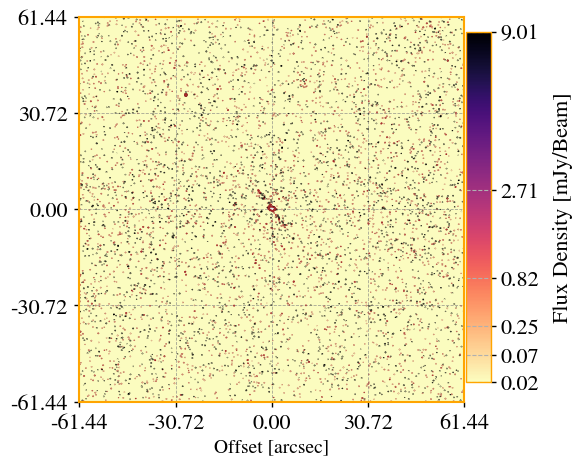

In [20]:
ax=mlibs.eimshow(input_data.filename)

##### Image too large to see the structure of the radio source? 
You can easily crop the image using the arguments `crop='True'` and `box_size=(size)`. Only squared boxes are fully supported.

  >> Center -->  [1536 1541    0    0]


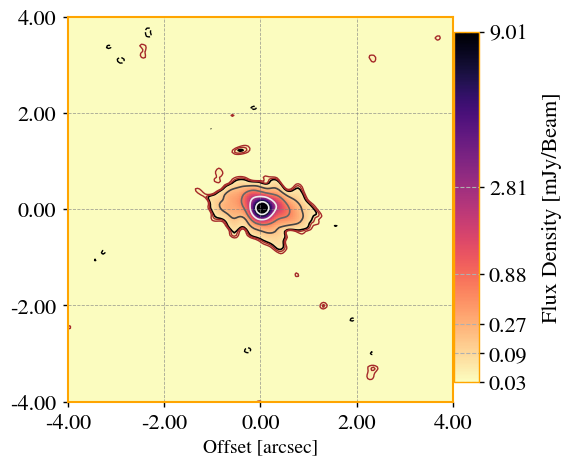

In [21]:
ax=mlibs.eimshow(input_data.filename, 
                 crop=True,box_size=(100),
                 center=None)

##### There are other several options to customize the plot.

  >> Center -->  [1536 1541    0    0]


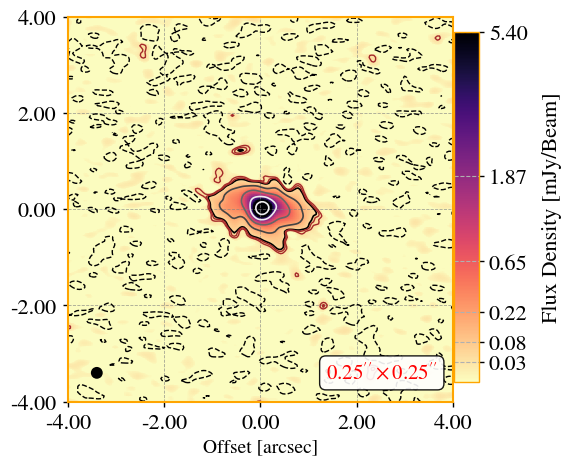

In [22]:
ax=mlibs.eimshow(input_data.filename,
                 add_beam=True,
                 crop=True,box_size=(100),
                 vmin_factor=1.0,vmax_factor=0.3, #level factor (max from peak, and min from std)
                 neg_levels=mlibs.np.asarray([-1]), # negative contours to draw -- which negative std level?
                 CM='magma_r',
       )

  >> Center -->  [1536 1541    0    0]


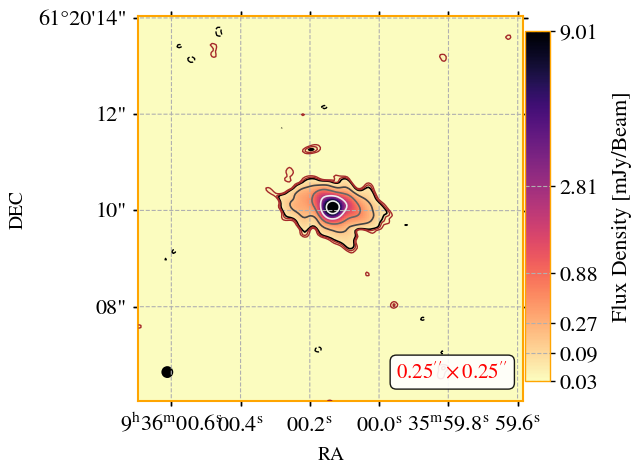

In [23]:
#change the projection of the image.
ax=mlibs.eimshow(input_data.filename,
                 add_beam=True,
                 crop=True,box_size=(100),
                 projection='celestial'
       )

  >> Center -->  [1536 1541    0    0]


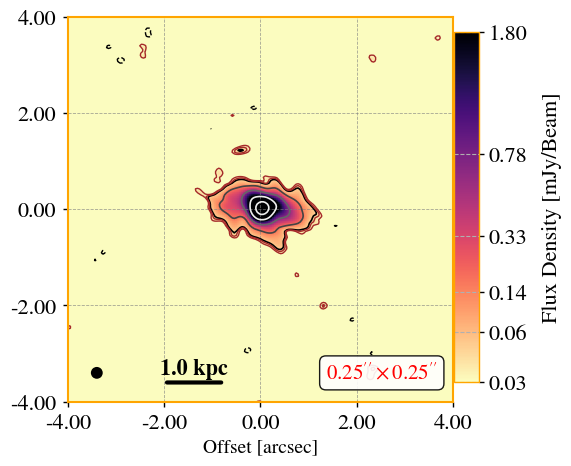

In [24]:
#If you provide at which redshift the source is located, you can also add a scale bar using
# astropy.units module.
ax=mlibs.eimshow(input_data.filename,
                 add_beam=True,
                 crop=True,box_size=(int(200/2)),
                 vmin_factor=3.0,vmax_factor=0.1,   #level factor (max from peak, and min from std)
                 neg_levels=mlibs.np.asarray([-3]), # negative contours to draw -- which negative std level?
                 CM='magma_r',
                 source_distance=mlibs.find_z_NED('UGC5101'), #in z
                 scalebar_length = 1.0*mlibs.u.kpc
       )

#### Performing image cutouts. 
If your image is too large to perform statistical analysis or the fitting, you should reduce its size to speed up things. A cutout can be made via `mlibs.cutout_2D_radec`. 

Note also that we are passing the residual file associated with the image, so that it will also be croped. 

[1536 1541    0    0]
09:35:51.600, +61.21.11.700, 9.999e+09Hz, I
143.96499999999997 61.35325


<Axes: xlabel='Offset [arcsec]'>

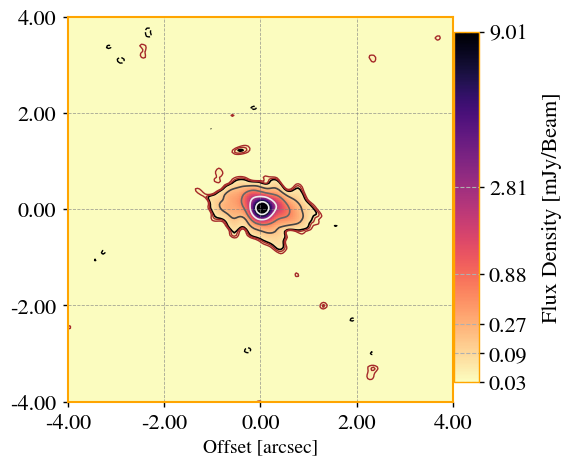

In [25]:
cutout_size = 200
ra,dec,new_filename = mlibs.cutout_2D_radec(imagename=input_data.filename,
                                            residualname=input_data.residualname,
                                            cutout_size = cutout_size)
mlibs.eimshow(new_filename)

You also can use the following if you wanna use those coordinates as a reference to cut other images to the same size and centre

In [26]:
for i in mlibs.tqdm(range(len(imagelist))):
    mlibs.cutout_2D_radec(imagename=imagelist[i],
                    residualname=residuallist[i],
                    ra_f=ra,dec_f=dec,
                    cutout_size = cutout_size,
                    special_name='')

100%|██████████| 2/2 [00:00<00:00, 63.59it/s]


But, then, you may need to reload the image files again.

In [27]:
prefix_images = '*MFS-image.cutout.fits'
imagelist = mlibs.glob.glob(root_path+prefix_images)
imagelist,residuallist = \
    mlibs.sort_list_by_beam_size(imagelist=imagelist,return_df = False)
    
# lets select another image from our list of images. 
idx = 0 #select one index from the list. 
input_data=mp.read_data(filename=imagelist[idx],
                        residualname=residuallist[idx])
    

100%|██████████| 2/2 [00:00<00:00, 178.22it/s]

0 >> selfcal_image_UGC05101.calibrated.avg12s_trial_1_3072x3072_0.04asec_100000.briggs.multiscale..0.5-MFS-image.cutout.fits
1 >> selfcal_image_UGC05101.calibrated.avg12s_trial_1_3072x3072_0.04asec_100000.briggs.multiscale..1.0-MFS-image.cutout.fits
++>> Image File: selfcal_image_UGC05101.calibrated.avg12s_trial_1_3072x3072_0.04asec_100000.briggs.multiscale..0.5-MFS-image.cutout.fits
++>> Residual File: selfcal_image_UGC05101.calibrated.avg12s_trial_1_3072x3072_0.04asec_100000.briggs.multiscale..0.5-MFS-residual.cutout.fits
-->> No PSF File was provided.


<Axes: xlabel='Offset [arcsec]'>

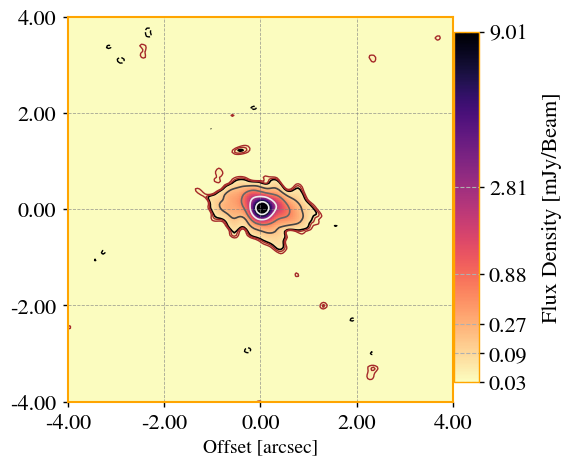

In [28]:
mlibs.eimshow(input_data.filename)

# Source Extraction and Model Constraints
Now, it is time to prepare ourselves for the image fitting. 

Before we head to the Sérsic fitting, we should inspect the structure of the emission. 
For that, we can perform a simple source extraction from the image and compute basic prior information, which includes:

1. Finding relevant regions of emission, and applying deblending where required. We will have the locations `(x0,y0)` of these regions.
2. Then, we compute first order sizes and effective intensities of these regions, for example $R_{50}$, $I_{50}$ and, additionally the Petrosian radius $R_{\rm p}$.
3. It is also relevant to quantify the axis ratio $q=b/a$ and position angles $PA$ of these structures. 

We use this prior information to construct a physically constrained Sérsic model. 

Note however that, necessarily, we do not require accurate shape properties from these individual regions. We are looking for initial physical constraints for our model, and those quantities will be optimised during minimisation.

To do this, we use the class `mp.source_extraction`, which allow us to find relevant regions of emission and determine our prior information. Only after that, one should proceed to the Sérsic fitting. 


### Testing the Source-Extraction
The source extraction uses the `SEP` or the `PetroFit` packages (`photutils`). `SEP` is a python implementation of the SExtractor algorithm (Bertin & Arnouts 1996), see (https://sep.readthedocs.io/en/v1.1.x/). To select which one one wants to use, use the argument `algorithm='SEP'` or `algorithm='PF'` in the class `mp.source_extraction`.

Note that the usage of these utilities require more testing across different images (radio --> optical). The default parameters may work well or not depending of your data, due to image size, artefacts, SNR, etc. 

You will need to play with the parameters below until you are happy with the detection. 
Parameters that are critical for the source detection/extractions are summarised below:
```
- bwf : int
    Box width fraction in terms of the beam size
    for the background estimation.
- bhf : int
    Box height fraction in terms of the beam size
    for the background estimation.
- fwf : int
    Filter width fraction in terms of the beam size
    for the background estimation.
- fhf : int
    Filter height fraction in terms of the beam size
    for the background estimation.
- deblend_nthresh : int (this is nlevels in Photutils)
    Number of thresholds used for object deblending. 
    Default is 32.
- deblend_nthresh : int (this is nlevels in Photutils)
    Number of thresholds used for object deblending. 
    Default is 32.
- clean_param : float (unique to SEP)
    Cleaning parameter for the source extraction.
    Default is 1.0.
- deblend_cont : float (this is contrast in Photutils)
    Minimum contrast ratio used for object deblending. Default is 0.005.
    
```

WARNING: This is implementation is in an early stage, so it is not completely automated. It is required that the user interacts with it in order to check if the source detection is feasible. That usually involves, from the default parameters below, run the source extraction in the image and check if it went well. If not (e.g. false detections, artefacts, etc), play around with the parameters until good detection is satisfied. 
Improvements are being made so that this can be escalated to multiple images. We also are planing to include AstroDendro and PyBDSF capabilities for this task of source detection in future updates.


Lets now run a source extraction in our image to extract relevant information. 


In [29]:
# lets select another image from our list of images. 
idx = 0
input_data=mp.read_data(filename=imagelist[idx],
                        residualname=residuallist[idx])

++>> Image File: selfcal_image_UGC05101.calibrated.avg12s_trial_1_3072x3072_0.04asec_100000.briggs.multiscale..0.5-MFS-image.cutout.fits
++>> Residual File: selfcal_image_UGC05101.calibrated.avg12s_trial_1_3072x3072_0.04asec_100000.briggs.multiscale..0.5-MFS-residual.cutout.fits
-->> No PSF File was provided.


In [30]:
image_data = input_data.image_data_2D
residual_data = input_data.residual_data_2D

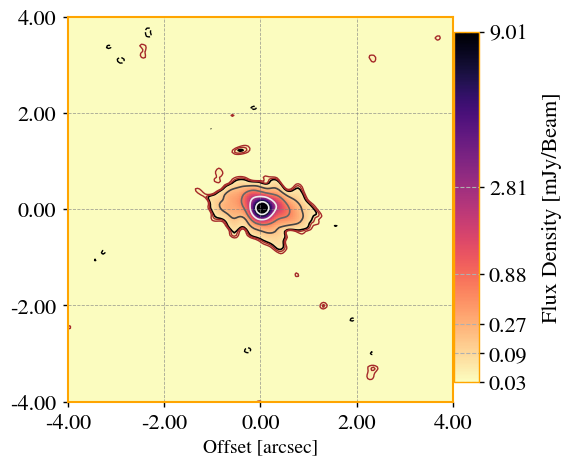

In [31]:
ax=mlibs.eimshow(input_data.filename,
        vmin_factor=3.0,vmax_factor=0.5, #level factor (max from peak, and min from std)
        neg_levels=np.asarray([-3]), # negative contours to draw -- which negative std level?
        CM='magma_r',
       )

In [32]:
#this is a set of parameters that may work OKAY
bwf, bhf = 1, 1 # standard value that works for a wide range of images. But, additional check is required!!!!
fwf, fhf = 1, 1 # standard value that works for a wide range of images. But, additional check is required!!!!
clean_param = 0.5
deblend_cont = 1e-3
deblend_nthresh = 60
sigma_mask = 8
sigma = 6
minarea_factor = 1 #no regions smaller than 1 beam size will be considered as structures.
# ell_size_factor = 2.5
ell_size_factor = 0.7*mlibs.get_ell_size_factor(psf_current = mlibs.get_beam_size_px(input_data.filename)[0])

To check if the source detection is good, you may pass the argument `dry_run=True` in the `mp.source_extraction` class, which will only display the regions detected, without performing any photometric calculations. 

This is useful in case you do not know for sure the noise structure of the image. Suppose that the number of structures detected are many (false detections, due to poor SNR or artefacts). That will take some time to compute their properties, which is not necessary. 

6.155474372435348
+++++++++++++++++++++++
SEP Filter sizes:
    bw,bh=( 6 6 )
    fw,fh=( 6 6 )
+++++++++++++++++++++++


++==>> INFO: Total number of Sources/Structures (deblended) =  1


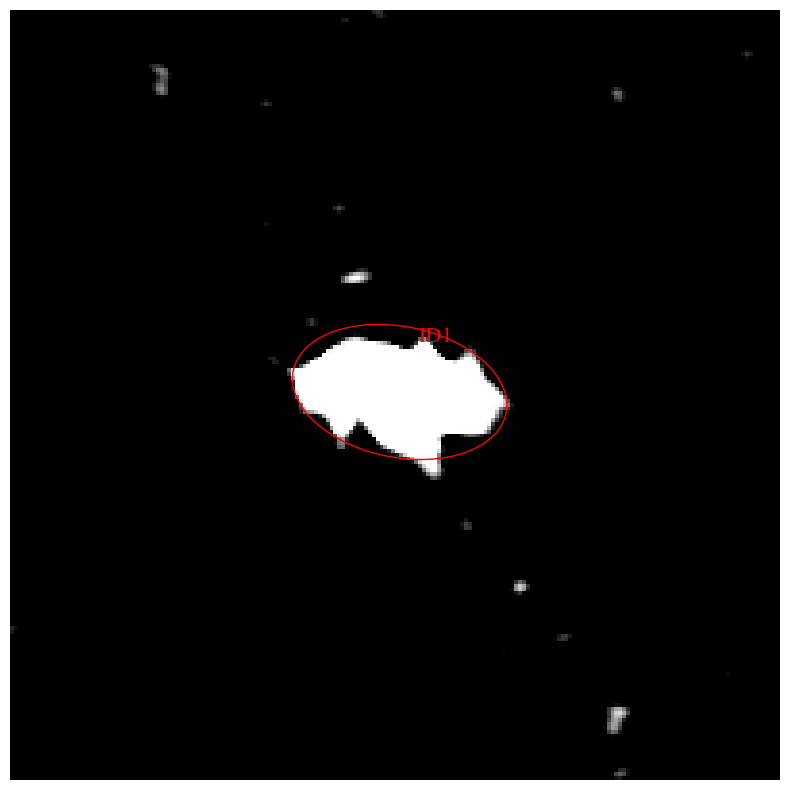

In [33]:

SE = mp.source_extraction(input_data, 
                          ell_size_factor = ell_size_factor, sigma = sigma,
                          bwf = bwf,bhf = bhf,fwf = fwf, fhf = fhf,
                          clean_param = clean_param, 
                          deblend_cont = deblend_cont, 
                          deblend_nthresh=deblend_nthresh,minarea_factor=minarea_factor,
                          apply_mask=False,sigma_mask=sigma_mask,dilation_size=None,
                          show_petro_plots=True,algorithm='SEP',
                          dry_run=True, obs_type = 'radio')
# plt.imshow(input_data.image_data_2D)

In [34]:
"""
SE = mp.source_extraction(input_data, 
                          ell_size_factor = ell_size_factor, sigma = sigma,
                          bwf = bwf,bhf = bhf,fwf = fwf, fhf = fhf,
                          clean_param = clean_param, 
                          deblend_cont = deblend_cont, 
                          deblend_nthresh=deblend_nthresh,minarea_factor=minarea_factor,
                          apply_mask=False,sigma_mask=sigma_mask,dilation_size=None,
                          algorithm='PF',
                          dry_run=True, obs_type = 'radio')
# plt.imshow(input_data.image_data_2D)
"""

"\nSE = mp.source_extraction(input_data, \n                          ell_size_factor = ell_size_factor, sigma = sigma,\n                          bwf = bwf,bhf = bhf,fwf = fwf, fhf = fhf,\n                          clean_param = clean_param, \n                          deblend_cont = deblend_cont, \n                          deblend_nthresh=deblend_nthresh,minarea_factor=minarea_factor,\n                          apply_mask=False,sigma_mask=sigma_mask,dilation_size=None,\n                          algorithm='PF',\n                          dry_run=True, obs_type = 'radio')\n# plt.imshow(input_data.image_data_2D)\n"

In [35]:
#print detection positions of each structure
SE.objects['xc'],SE.objects['yc']

(array([100]), array([100]))

### Decomposition of the Radio Emission
Before running the source extraction again, with `dry_run=False`, lets pay attention to a very critical point.

By a 'structure' or 'source', we mean a spatial region responsible for emitting (radio) emission: 
1. This region/source/structure can be simple, mono-component such as a blob or a compact structure.
2. Or this region/source/structure can be composite/complicated, having a compact structure surrounded by other structures, such as diffuse emission. So, this structure would not be 'mono-component', but 'multi-component'.
  
In principle, the detection algorithm used here will not distinguish such composite cases.
This is not deblending, because they are actually overlapping structures. 
Hence, they are identified as just a source. 

So, we have to investigate the following question: 

***Is a single model component (a single Sersic function) enough to model each detected individual structure?***

We differentiate a detected region/structure by its `ID`, so structure `ID`. In the example above, we may conclude that structure `ID1` is more complex than a mono-component, hence source `ID1` is multi-component.

Lets see the data again:

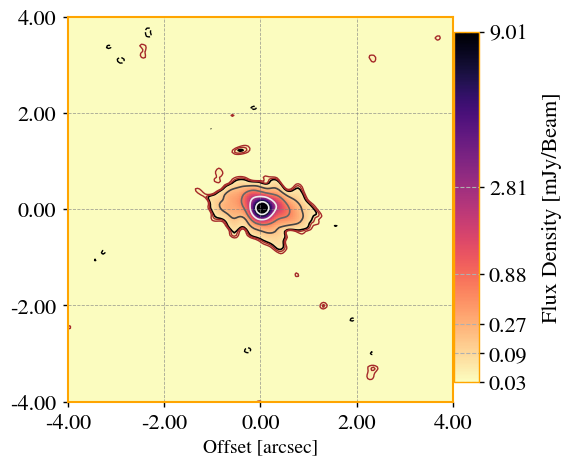

In [36]:
ax=mlibs.eimshow(input_data.filename)

It is clear that some material is surrounding the central structure (`ID1`).

#### So the answer to our question:
##### ***Is a single model component (a single Sersic function) enough to model each detected individual source?*** 
is
##### ***Probably not!*** 

We see that `ID1` is a composite, containing a compact structure surrounded by some asymmetric and more diffuse 
emission. In this case, when modelling this source with the Sersic decomposition, we have to tell the algorithm that `ID1` 
is composite and requires more than one model component. 

In the `mp.source_extraction` class, the argument used for this is `ids_to_add`, 
which is a list of IDs where we want to add extra model components. The function called to do this is `mlibs.add_extra_component`.


In our case, to add another model component to `ID1`, we use `ids_to_add = ['1']`. So, our source `ID1` will be decomposed into two model components.

For example, in our case originally we had `ID_1 -> COMP_1`, then `COMP_2` will be a copy of `COMP_1` with the following modifications:
<!-- - the positions of `COMP_1`, `(x0,y0)` are copied onto `COMP_2`. -->
- the starting constraint of the effective radius of `COMP_2` is 3 times of that of `COMP_1`.
- the starting constraint of the effective intensity of `COMP_2` is 0.1 times of that of `COMP_1`.

Now, in our example, we have `ID_1 -> (COMP_1, COMP_2)`.

***Note that at the current stage of `morphen`, this is a manual step. In a future version this will be fully automated.***



If you are happy with the source detection, have decided how many components (`COMP_`s) do you need, and have attributed the components to corresponding source `ID`s, you may proceed. Remember to set `dry_run = False`.

6.155474372435348
 ==>  Dilation size is 3 [px]
+++++++++++++++++++++++
SEP Filter sizes:
    bw,bh=( 6 6 )
    fw,fh=( 6 6 )
+++++++++++++++++++++++
++==>> INFO: Total number of Sources/Structures (deblended) =  1


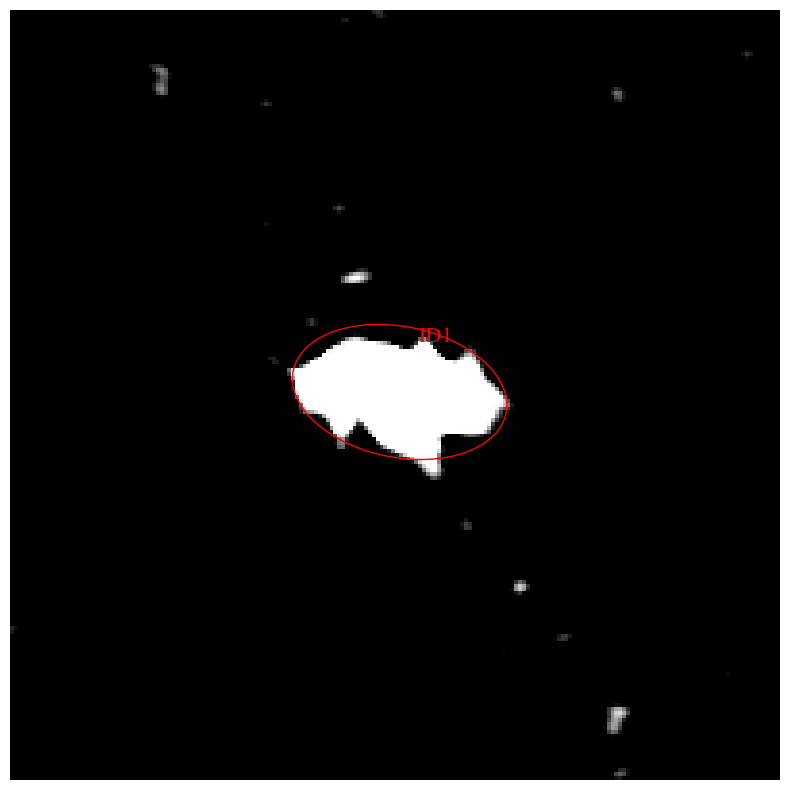

INFO: Using Elliptical Gaussian for Gaussian beam convolution.
# of structures (IDs) to be fitted = 1
# of model components (COMPS) to be fitted = 2


2024-03-25 18:00:16	WARN	componentlist::close	componentlist closed


In [37]:
SE = mp.source_extraction(input_data, 
                          ids_to_add=['1'], #set that ID1 require an additional model component.
                          ell_size_factor = ell_size_factor, sigma = sigma,
                          bwf = bwf,bhf = bhf,fwf = fwf, fhf = fhf,
                          clean_param = clean_param, 
                          deblend_cont = deblend_cont, 
                          deblend_nthresh=deblend_nthresh,minarea_factor=minarea_factor,
                          apply_mask=False,sigma_mask=sigma_mask,dilation_size=None,
                          show_petro_plots=False,algorithm='SEP',
                          dry_run=False, obs_type = 'radio')
# plt.imshow(input_data.image_data_2D)

When using `mp.source_extraction` (`SE`) with `dry_run = False`, it returns a dictionary with basic photometric information of each source (`SE.sources_photometries`, see below).  For that, the function `mlibs.prepare_fit` is be called. The basic photometry of each region is determined via `mlibs.compute_petro_source`.

If in the previous step no extra component was added (i.e. `ids_to_add = []`), this dictionary will have the same number of model components as the number of detection sources/structures/regions. 

When another extra component is added, components that are added to a source ID will contain similar information as the parent ID. 

The dictionary containing basic photometry of each structure is:

In [38]:
SE.sources_photometries

{'c1_PA': -11.113398341233832,
 'c1_q': 0.6168281787746661,
 'c1_area': 1485.0,
 'c1_Re': 21.741439257393452,
 'c1_x0c': 100.72167175595297,
 'c1_y0c': 100.25782358416919,
 'c1_label': 1,
 'c1_R50': 5.91498299659932,
 'c1_R20': 3.0584116823364673,
 'c1_R80': 11.233246649329866,
 'c1_C1': 0.5650093509225577,
 'c1_Snu': 1.3305585269824145,
 'c1_Rp': 13.521904380876174,
 'c1_Rpidx': 27,
 'c1_rlast': 43,
 'c1_I50': 0.003896543732844293,
 'ncomps': 2,
 'c2_PA': -11.113398341233832,
 'c2_q': 0.6168281787746661,
 'c2_area': 1485.0,
 'c2_Re': 21.741439257393452,
 'c2_x0c': 100.72167175595297,
 'c2_y0c': 100.25782358416919,
 'c2_label': 1,
 'c2_R50': 17.744948989797958,
 'c2_R20': 3.0584116823364673,
 'c2_R80': 11.233246649329866,
 'c2_C1': 0.5650093509225577,
 'c2_Snu': 1.3305585269824145,
 'c2_Rp': 13.521904380876174,
 'c2_Rpidx': 27,
 'c2_rlast': 43,
 'c2_I50': 0.0003896543732844293}

In [39]:
# print the initial conditions of the parameters
for i in range(1,SE.sources_photometries['ncomps']+1):
    print(f"(R50, I50) COMP_{i} = ({SE.sources_photometries['c'+str(i)+'_R50']:.2f},"
                                 f"{SE.sources_photometries['c'+str(i)+'_I50']:.4f})")


(R50, I50) COMP_1 = (5.91,0.0039)
(R50, I50) COMP_2 = (17.74,0.0004)


#### A more complicated example, to demonstrate the feasibility of this method, is shown at the end of this notebook.

# Sersic Multi-Fit
Now, we are ready to proceed for to the fitting part. 

We use the source extraction object `SE` to feed it into the multi-sersic fitting, called by the class `mp.sersic_multifit_radio`.

#### Relevant arguments:

##### Fixed Sersic indeces:
```
    fix_n : list (same shape as the number of components)
        List of booleans to fix the Sersic index.
        Default is None, will attibute True to all elements.
    fix_value_n : list (same shape as the number of components)
        List of values to fix the Sersic index.
        Default is None, will attribute 0.5 to all elements. 
```
Fix or not the Sersic indeces of each component (`fix_n`) and to which value it should be fixed (`fix_value_n`). 
By default, the code fixes all Sersic indeces to `n=0.5` for all model components. If an element of this list is `fix_n = [True]`, a value can be set using `fix_value_n = [1.0]`, for example. The size of the list must be the same as the number of components (`SE.sources_photometries['ncomps']`).

##### Fixed positions:

```
    dr_fix : list (same shape as the number of components)
        List of values to fix radially (dr) the positions x0,y0. 
        This will be the max boundary for each direction x and y.
        Default is None, will attribute 10 to all elements.

```

It also fixes all components to its detected positions `(x0,y0)` during the source extraction step, but gives a search interval of +/-10 px during the optimisation. 

You can modify these options by passing the arguments `dr_fix = [3,50]`, meaning that `COMP_1` is very spatially constrained to its detection location, and can vary only +/- 3 pixels, while `COMP_2` (our additional component for structure `ID1`) is spatially constrained to a larger bound, the algorithm will search in the boundary of +/- 50 pixels during optimisation relative to the detection coordinates.

##### Fix geometrical grid:

```
    fix_geometry : list bool, optional
        If True, then the geometry of the components will be fixed to elliptical geometry
        The default is [True,].
```
From [(Peng et al., 2002)]('https://ui.adsabs.harvard.edu/abs/2002AJ....124..266P/abstract'), the geometry of the model grid (`np.meshgrid`) can be changed with the boxiness parameter `C`. The default in `morphen` is to use `True` for all model components (as `False` is showing signs of instabilities). Setting true, will set the parameter `C` to `0.0`. 

##### Labeling compact and diffuse components.

Another important observation is that, since we want to decompose the structure in terms of compact and diffuse emission, we must specify which model components corresponds to compact structures and diffuse structures. In our case, we may want to label `COMP_1` as our compact model, and `COMP_2` as our diffuse model. The argument `comp_ids` is used for that. 

```
    comp_ids : list
        List of integers or strings that indicates which components are compact.
        Default is ['1'], will label `COMP_1` as compact.
```
In our example, we use `comp_ids=['1']`. Do not worry about the labels of extended components, the algorithm will determine automatically by exclusion (in our case, will be `2`). 

If your model had a single model component (e.g. in the previous step, you have used `ids_to_add = []`), diffuse structures will be considered to be the residual only. 

***A comprehensive example using 8 model components (YES, THAT IS RIGHT, EIGHT!!) is provided at the end of this notebook.***


#### Performing the fitting.

In the fitting example provided below, we are going to set the Sersic index of `COMP_1` to `0.5` and keep 
free the one for `COMP_2`. 


In [40]:
# fix_geometry = [True] * SE.n_IDs + [True]
# dr_fix = [5] * SE.n_IDs + [25]
# fix_value_n = [0.5] * SE.n_IDs + [0.5]
# fix_n = [True] * SE.n_IDs + [True]

2024-03-25 18:56:02 - INFO -  ++>> Fitting without a mask.



                                                          ..___|**_
                                                  .|||||||||*+@+*__*++.
                                              _||||.           .*+;].,#_
                                         _|||*_                _    .@@@#@.
                                   _|||||_               .@##@#| _||_
       Morphen                |****_                   .@.,/\..@_.
                             #///#+++*|    .       .@@@;#.,.\@.
                              .||__|**|||||*||*+@#];_.  ;,;_
 Geferson Lucatelli                            +\*_.__|**#
                                              |..      .]]
                                               ;@       @.*.
                                                #|       _;]];|.
                                                 ]_          _+;]@.
                                                 _/_             |]\|    .  _
                                              ...._@* __ .

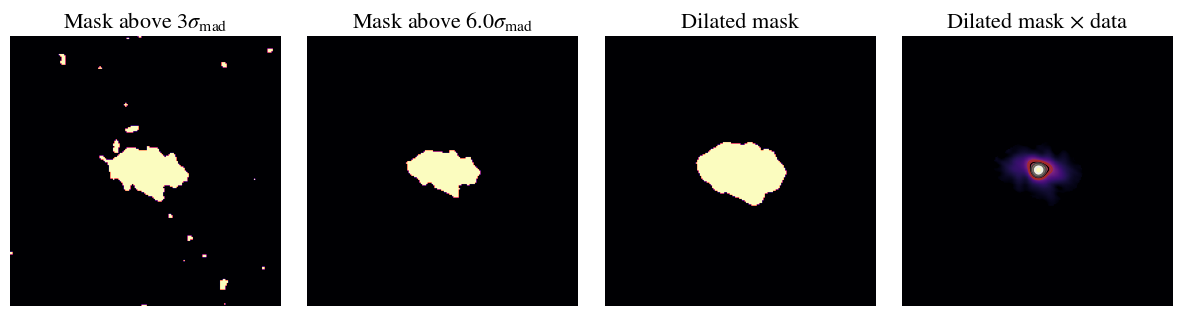

2024-03-25 18:56:03	WARN	componentlist::close	componentlist closed
2024-03-25 18:56:02 - DEBUG - ---------------------------------------
2024-03-25 18:56:02 - DEBUG -  <<< PERFORMING CONVOLUTION WITH JAX >>> 
2024-03-25 18:56:02 - DEBUG - ---------------------------------------
2024-03-25 18:56:02 - DEBUG -  ==> Using clean shuffled background for optmization... 


INFO: Using Elliptical Gaussian for Gaussian beam convolution.
 ++==>> Limiting x0=100.72167175595297+/-3
 ++==>> Limiting y0=100.25782358416919+/-3
++==>> Fixing sersic index of component 1  to 0.5.
 ++==>> Limiting x0=100.72167175595297+/-50
 ++==>> Limiting y0=100.25782358416919+/-50
{'f1_x0': {'value': 100.72167175595297, 'min': 97.72167175595297, 'max': 103.72167175595297}, 'f1_y0': {'value': 100.25782358416919, 'min': 97.25782358416919, 'max': 103.25782358416919}, 'f1_PA': {'value': -11.113398341233832, 'min': -101.11339834123383, 'max': 78.88660165876617}, 'f1_ell': {'value': 0.3831718212253339, 'min': 0.07663436424506678, 'max': 0.75}, 'f1_n': {'value': 0.5, 'min': 0.49, 'max': 0.51}, 'f1_In': {'value': 0.003896543732844293, 'min': 0.0003896543732844293, 'max': 1.9482718664221466}, 'f1_Rn': {'value': 5.91498299659932, 'min': 1.182996599319864, 'max': 8.872474494898979}, 'f1_cg': {'value': 0.0, 'min': -0.01, 'max': 0.01}, 'f2_x0': {'value': 100.72167175595297, 'min': 50.72167175

/media/sagauga/xfs_evo/cloud/OnedriveUoM/PhD_UoM/GitHub/morphen_dev/image_decomposition/../libs/fitEllipse.py:262: RuntimeWarning: invalid value encountered in divide
  qmedian = np.nanmedian(BB / AA)
/media/sagauga/xfs_evo/cloud/OnedriveUoM/PhD_UoM/GitHub/morphen_dev/image_decomposition/../libs/fitEllipse.py:264: RuntimeWarning: invalid value encountered in divide
  qmi = np.nanmedian((BB / AA)[:rsplit])
/home/sagauga/miniconda3/envs/morphen_stable/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,
/media/sagauga/xfs_evo/cloud/OnedriveUoM/PhD_UoM/GitHub/morphen_dev/image_decomposition/../libs/fitEllipse.py:265: RuntimeWarning: invalid value encountered in divide
  qmo = np.nanmedian((BB / AA)[rsplit:])


     -->> ERROR when computing Petrosian properties. Will flag error_petro as True.


100%|██████████| 10/10 [00:00<00:00, 63.06it/s]
/media/sagauga/xfs_evo/cloud/OnedriveUoM/PhD_UoM/GitHub/morphen_dev/image_decomposition/../libs/fitEllipse.py:262: RuntimeWarning: invalid value encountered in divide
  qmedian = np.nanmedian(BB / AA)
/media/sagauga/xfs_evo/cloud/OnedriveUoM/PhD_UoM/GitHub/morphen_dev/image_decomposition/../libs/fitEllipse.py:264: RuntimeWarning: invalid value encountered in divide
  qmi = np.nanmedian((BB / AA)[:rsplit])
/media/sagauga/xfs_evo/cloud/OnedriveUoM/PhD_UoM/GitHub/morphen_dev/image_decomposition/../libs/fitEllipse.py:265: RuntimeWarning: invalid value encountered in divide
  qmo = np.nanmedian((BB / AA)[rsplit:])


Computing properties of model component:  selfcal_image_UGC05101.calibrated.avg12s_trial_1_3072x3072_0.04asec_100000.briggs.multiscale..0.5-MFS-image.cutout_dec_model_component_2.fits


100%|██████████| 10/10 [00:00<00:00, 68.05it/s]


Computing properties of model component:  selfcal_image_UGC05101.calibrated.avg12s_trial_1_3072x3072_0.04asec_100000.briggs.multiscale..0.5-MFS-image.cutout_model_component_1.fits


100%|██████████| 10/10 [00:00<00:00, 71.66it/s]


Computing properties of model component:  selfcal_image_UGC05101.calibrated.avg12s_trial_1_3072x3072_0.04asec_100000.briggs.multiscale..0.5-MFS-image.cutout_model_component_2.fits


/media/sagauga/xfs_evo/cloud/OnedriveUoM/PhD_UoM/GitHub/morphen_dev/image_decomposition/../libs/libs.py:2417: RuntimeWarning: invalid value encountered in divide
  radial_prof = np.histogram(r, bins, weights=(image * weights * mask))[0] / \
100%|██████████| 10/10 [00:00<00:00, 71.89it/s]


  ++>> Total component IDs modelled: ['1' '2']
  ++>> IDs attributed to compact structures: ['1']
  ++>> IDs attributed to extended structures: ['2']


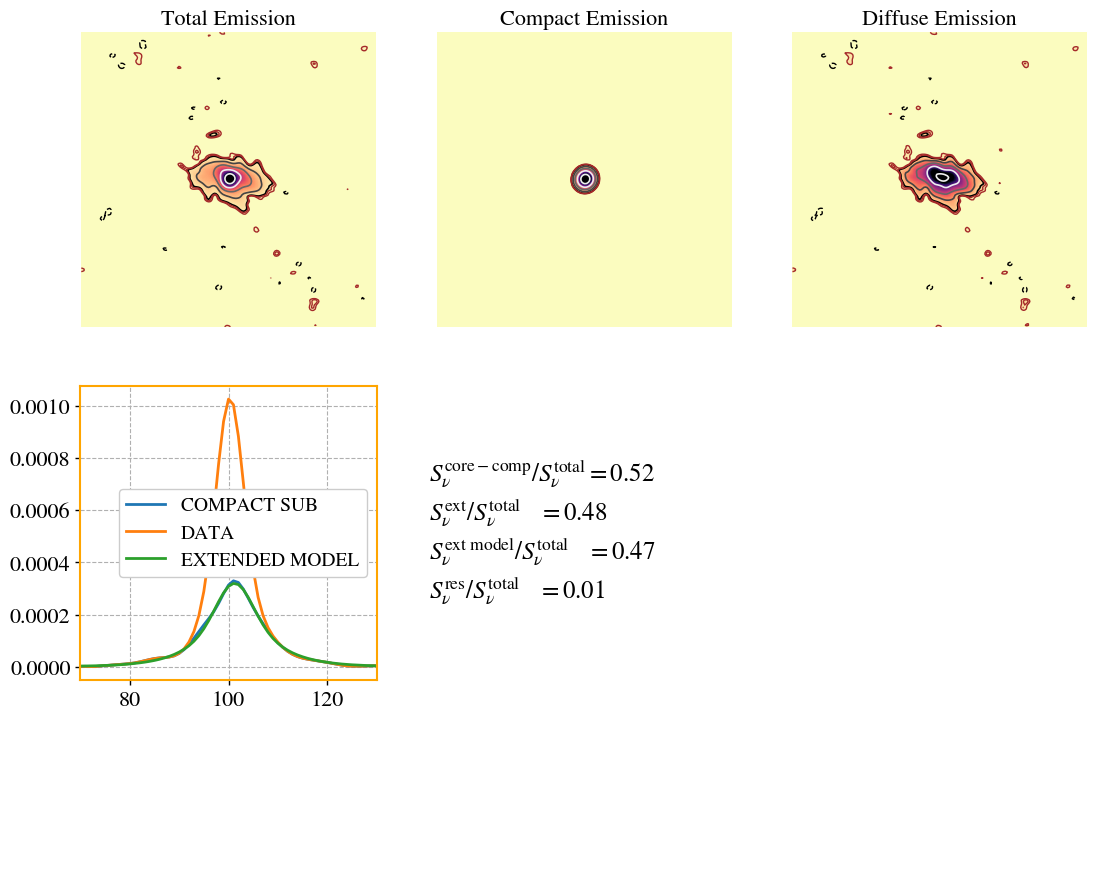

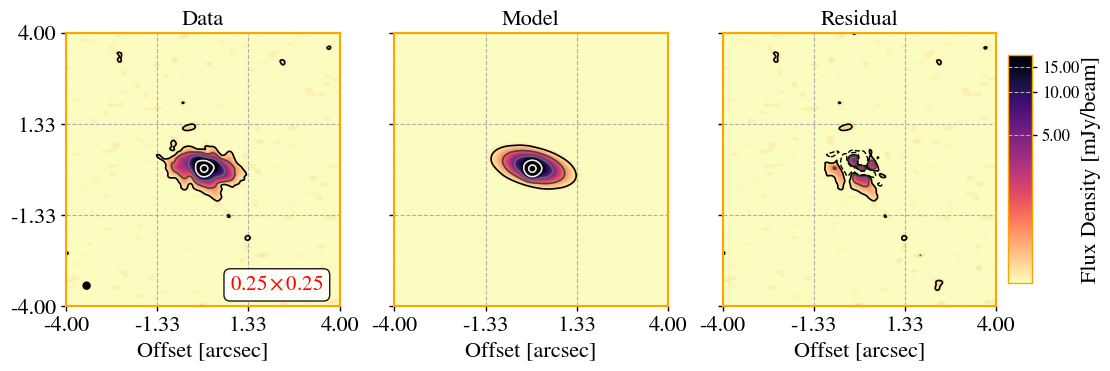

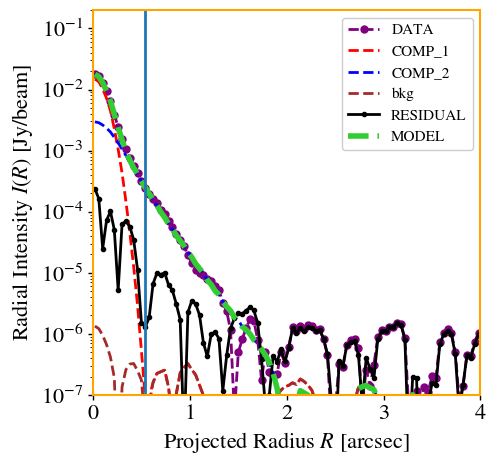

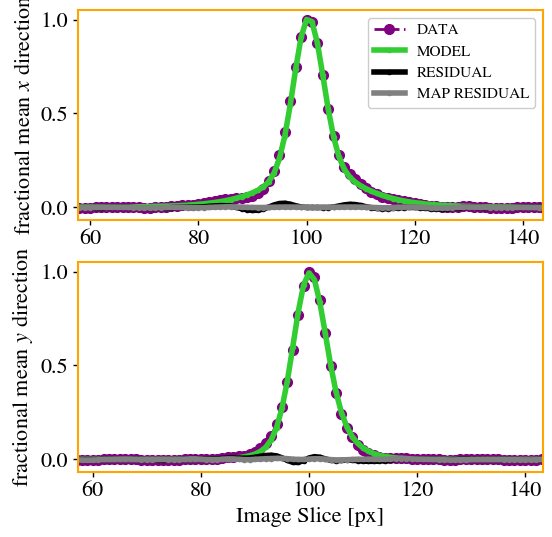

/media/sagauga/xfs_evo/cloud/OnedriveUoM/PhD_UoM/GitHub/morphen_dev/image_decomposition/../libs/fitEllipse.py:262: RuntimeWarning: invalid value encountered in divide
  qmedian = np.nanmedian(BB / AA)
/media/sagauga/xfs_evo/cloud/OnedriveUoM/PhD_UoM/GitHub/morphen_dev/image_decomposition/../libs/fitEllipse.py:264: RuntimeWarning: invalid value encountered in divide
  qmi = np.nanmedian((BB / AA)[:rsplit])
/home/sagauga/miniconda3/envs/morphen_stable/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,
/media/sagauga/xfs_evo/cloud/OnedriveUoM/PhD_UoM/GitHub/morphen_dev/image_decomposition/../libs/fitEllipse.py:265: RuntimeWarning: invalid value encountered in divide
  qmo = np.nanmedian((BB / AA)[rsplit:])


     -->> ERROR when computing Petrosian properties. Will flag error_petro as True.


/media/sagauga/xfs_evo/cloud/OnedriveUoM/PhD_UoM/GitHub/morphen_dev/image_decomposition/../libs/libs.py:2417: RuntimeWarning: invalid value encountered in divide
  radial_prof = np.histogram(r, bins, weights=(image * weights * mask))[0] / \
/media/sagauga/xfs_evo/cloud/OnedriveUoM/PhD_UoM/GitHub/morphen_dev/image_decomposition/../libs/fitEllipse.py:262: RuntimeWarning: invalid value encountered in divide
  qmedian = np.nanmedian(BB / AA)
/media/sagauga/xfs_evo/cloud/OnedriveUoM/PhD_UoM/GitHub/morphen_dev/image_decomposition/../libs/fitEllipse.py:264: RuntimeWarning: invalid value encountered in divide
  qmi = np.nanmedian((BB / AA)[:rsplit])
/media/sagauga/xfs_evo/cloud/OnedriveUoM/PhD_UoM/GitHub/morphen_dev/image_decomposition/../libs/fitEllipse.py:265: RuntimeWarning: invalid value encountered in divide
  qmo = np.nanmedian((BB / AA)[rsplit:])
2024-03-25 18:56:13 - INFO - +--------------------------------+
2024-03-25 18:56:13 - INFO - | Core-Compact Component Sizes |
2024-03-25 18:56

In [194]:
reload_libs()
smfr = mp.sersic_multifit_radio(input_data,
                                SE, #source extraction object, from previous step
                                convolution_mode='GPU',
                                which_residual = 'shuffled', # shuffled, natural or user (natural is experimental!)
                                fix_geometry=[True,True], #for stability purposes, keep True for now. 
                                comp_ids=['1'],# which component label is compact?
                                dr_fix=[3,50],#for each component, radial element size to fix (x0,y0) positions                                
                                fix_n=[True,False],#for each component, fix or not the Sersic index. 
                                fix_value_n=[0.5,None],#for each component, the Sersic index value to be fixed. 
                                aspect='elliptical',#elliptical or circular gaussian for beam convolution? 
                                z = mlibs.find_z_NED('UGC5101'))

## Analysing Results

All results are stored in the object `smfr`. 

### Fitting parameters results
By default, the minimisation will be run twice. This is a strategy used by `LMFIT` that helps on the convergence of parameters. The results from the first run can be obtained from `smfr.lmfit_results_1st_pass[0]` and the parameters from the final run from `smfr.lmfit_results[0]`.

In [195]:
smfr.lmfit_results[0]

Parameters([('f1_x0', <Parameter 'f1_x0', value=99.08950058514685 +/- 0.0151, bounds=[97.72167175595297:103.72167175595297]>), ('f1_y0', <Parameter 'f1_y0', value=98.63482505837513 +/- 0.0107, bounds=[97.25782358416919:103.25782358416919]>), ('f1_PA', <Parameter 'f1_PA', value=64.73492885081382 +/- 0.544, bounds=[-101.11339834123383:78.88660165876617]>), ('f1_ell', <Parameter 'f1_ell', value=0.49077277430240124 +/- 0.0113, bounds=[0.07663436424506678:0.75]>), ('f1_n', <Parameter 'f1_n', value=0.4900000000000137 +/- 0.187, bounds=[0.49:0.51]>), ('f1_In', <Parameter 'f1_In', value=0.10842948289643366 +/- 0.0265, bounds=[0.0003896543732844293:1.9482718664221466]>), ('f1_Rn', <Parameter 'f1_Rn', value=1.1829965993198641 +/- 0.222, bounds=[1.182996599319864:8.872474494898979]>), ('f1_cg', <Parameter 'f1_cg', value=0.00999999999973538 +/- 0.552, bounds=[-0.01:0.01]>), ('f2_x0', <Parameter 'f2_x0', value=100.11927990506112 +/- 0.0114, bounds=[50.72167175595297:150.72167175595297]>), ('f2_y0', <Parameter 'f2_y0', value=99.95362974622782 +/- 0.00791, bounds=[50.25782358416919:150.2578235841692]>), ('f2_PA', <Parameter 'f2_PA', value=-14.408698954958732 +/- 0.0732, bounds=[-101.11339834123383:78.88660165876617]>), ('f2_ell', <Parameter 'f2_ell', value=0.5966046213812144 +/- 0.00138, bounds=[0.07663436424506678:0.75]>), ('f2_n', <Parameter 'f2_n', value=0.9912274674708241 +/- 0.0184, bounds=[0.3:8.0]>), ('f2_In', <Parameter 'f2_In', value=0.0015119104596626766 +/- 5.02e-05, bounds=[3.8965437328442933e-05:0.19482718664221466]>), ('f2_Rn', <Parameter 'f2_Rn', value=9.463234059657896 +/- 0.482, bounds=[3.548989797959592:26.617423484696936]>), ('f2_cg', <Parameter 'f2_cg', value=0.00999941391329973 +/- 0.0308, bounds=[-0.01:0.01]>), ('s_a', <Parameter 's_a', value=0.9900000000001581 +/- 0.136, bounds=[0.99:1.01]>)])

#### Parameter uncertainties
Parameter uncertainties are obtained from the covariance matrix of the fit. Uncertainties are only available when using the 
`least_squares` method (default in `morphen`). Such parameters can be accessed via `smfr.lmfit_results[0][param_name].stderr`.

In [196]:
smfr.lmfit_results[0]['f1_Rn'].stderr, \
    smfr.lmfit_results[0]['f1_n'].stderr, \
        smfr.lmfit_results[0]['f1_In'].stderr

(0.22203828298011563, 0.18734013797601484, 0.026495493174800745)

In [197]:
smfr.lmfit_results[0]['f2_Rn'].stderr, \
    smfr.lmfit_results[0]['f2_n'].stderr, \
        smfr.lmfit_results[0]['f2_In'].stderr

(0.48188585824501873, 0.018400494481265073, 5.018658093331947e-05)

### Generated files
Model images (convolved and deconvolved) are saved as `.fits` files having a copy of the header 
from the original image file data. Example of these files are: 
 - `*_dec_model.fits` >> Deconvolved total model image.
 - `*_conv_model.fits` >> Convolved total model image.
 - `*_residual.fits` >> Residual model image. 
 - `*_dec_model_component_i.fits` >> Deconvolved model image for model component `i`. `i` vary from 1 to the total number of model components.
 - `*_model_component_i.fits` >> Convolved model image for model component `i`.
 - `*_compact.fits` >> Convolved model image containing all compact structures.
 - `*_dec_compact.fits` >> Deconvolved model image containing all compact structures.
 - `*_ext_model.fits.fits` >> Convolved model image containing all extended structures.
 - `*_dec_ext_model.fits.fits` >> Deconvolved model image containing all extended structures.
 - `*_extended.fits` >> Convolved image containing the extended structures. This is obtained by `extended = data - conv_compact`.
 - `*_fit.pickle` >> Contains a pickle object with all the `LMFIT` results.
 - `*_fit_modeldict.pickle` >> Contains a pickle object with all model components images (convolved and deconvolved). Note, this is a large file, and probably will be removed in a future version.
 - `*_model_mini_params.csv` >> contain the best-fit minimised parameters and (when possible) standard errors.
 - `*_mini_corr.csv` >> When successful, this contains the correlation matrix for the model parameters. 


All files are overwritten if the fitting function is called again.

## The structure of the diffuse emission
Lets visualise the model images of our fitting. The 2D model images are stored in `smfr.models[0]`. 
Deconvolved model components are labelled as `smfr.models[0]['model_ci']` and convolved model components 
as `smfr.models[0]['model_ci_conv']`. 

In [198]:
smfr.models[0]

{'model_c1': array([[-6.6140492e-06,  4.4228309e-06,  8.9032392e-06, ...,
         -8.9085461e-06,  3.9010615e-06,  1.5295476e-06],
        [-3.9448191e-06, -7.7736995e-06, -3.8119049e-06, ...,
         -1.5373877e-07, -2.4957735e-06,  7.6646593e-06],
        [-9.7300381e-06, -6.0147786e-06, -4.8615192e-07, ...,
          7.6094520e-06, -5.8740989e-06, -1.8322702e-06],
        ...,
        [ 1.3556466e-06,  2.6654534e-06,  1.4327434e-05, ...,
         -9.7240718e-06, -2.1937124e-06, -4.7011170e-07],
        [ 3.4679510e-06, -6.4260112e-06, -2.2434533e-06, ...,
         -2.3766547e-07, -1.0599479e-05,  1.8372667e-06],
        [ 1.1463574e-05, -6.8986974e-06, -9.3303261e-06, ...,
          5.8855244e-06,  4.2842034e-06, -1.1142832e-05]], dtype=float32),
 'model_c1_conv': array([[-3.9986512e-07, -3.8151623e-07, -2.6956667e-07, ...,
         -3.7207951e-07, -3.6463263e-07, -2.9232305e-07],
        [-6.1501089e-07, -6.2917144e-07, -5.1197679e-07, ...,
         -6.0797532e-07, -6.0151405e-07

Text(0.5, 1.0, 'Data')

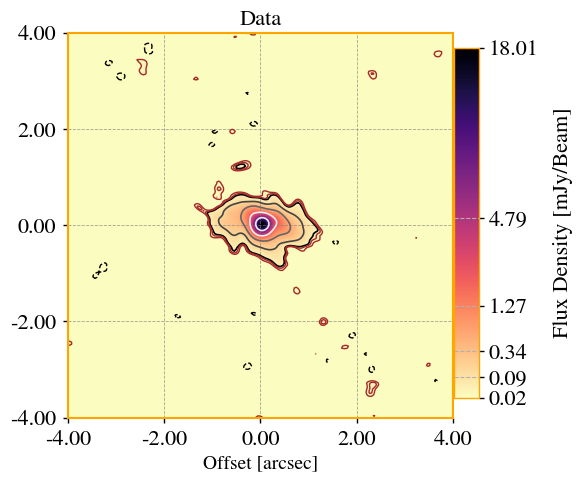

In [199]:
# center = nd.maximum_position(input_data.image_data_2D)
center = (int(smfr.results_fit['f1_x0'][0]),int(smfr.results_fit['f1_y0'][0]))
rms = input_data.rms_res
ax = mlibs.eimshow(input_data.filename,
             crop=False,box_size=150,vmax_factor=1.0,
             vmax=input_data.image_data_2D.max(),rms=rms)
ax.set_title('Data')

Text(0.5, 1.0, 'Diffuse Emission')

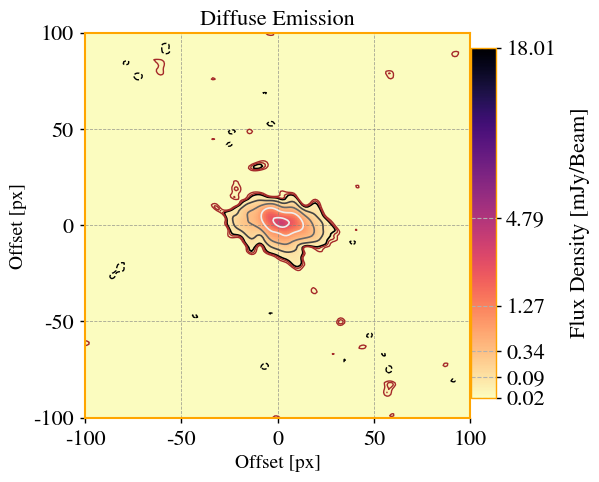

In [200]:
ax = mlibs.eimshow(input_data.image_data_2D- smfr.compact_model,
        crop=False,box_size=150,vmax_factor=1.0,
        rms=rms,vmax=input_data.image_data_2D.max())
ax.set_title('Diffuse Emission')

Text(0.5, 1.0, 'Compact Deconvolved')

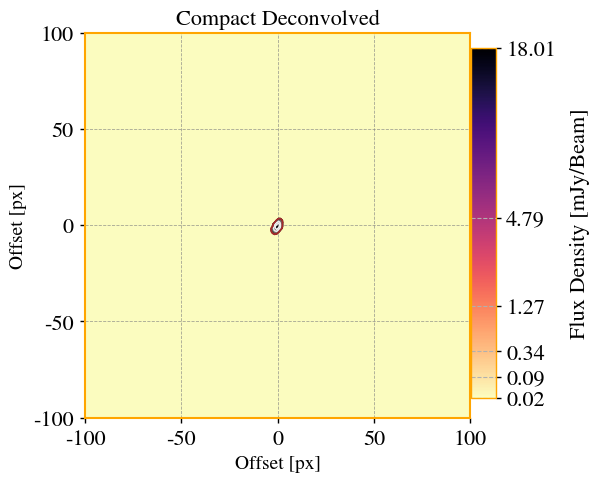

In [201]:
ax=mlibs.eimshow(smfr.models[0]['model_c1'],
           crop=False,box_size=50,rms=rms,
           vmax=input_data.image_data_2D.max())
ax.set_title('Compact Deconvolved')

Text(0.5, 1.0, 'Compact Convolved')

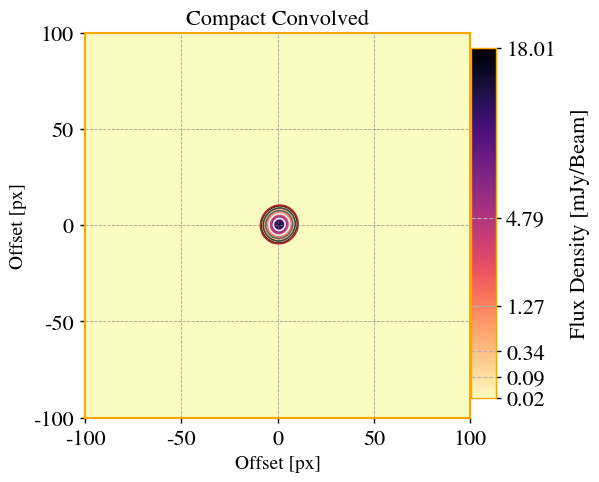

In [202]:
ax=mlibs.eimshow(smfr.models[0]['model_c1_conv'],
           crop=False,box_size=50,rms=rms,
           vmax=input_data.image_data_2D.max())
ax.set_title('Compact Convolved')

We can access the total deconvolved model image from `smfr.models[0]['model_total_dec']`, 
while the convolved total model image is stored in `smfr.models[0]['model_total_conv']`.

Text(0.5, 1.0, 'Model Deconvolved')

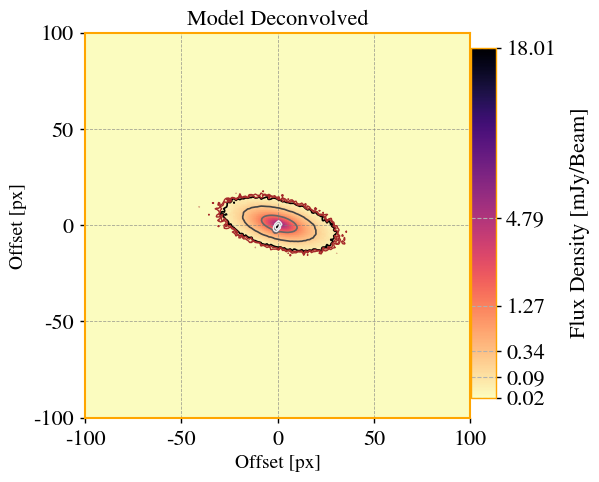

In [203]:
ax=mlibs.eimshow(smfr.models[0]['model_total_dec'],
           crop=False,box_size=150,rms=rms,
           vmax=input_data.image_data_2D.max())
ax.set_title('Model Deconvolved')

Text(0.5, 1.0, 'Model Convolved')

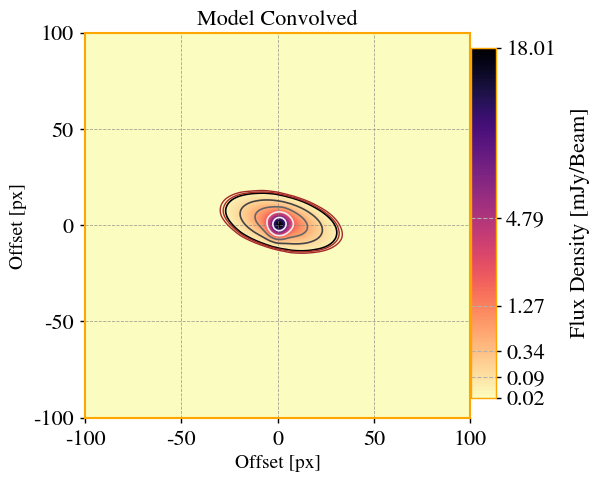

In [204]:
ax=mlibs.eimshow(smfr.models[0]['model_total_conv'],
           crop=False,box_size=150,rms=rms,
           vmax=input_data.image_data_2D.max())
ax.set_title('Model Convolved')

Finally, the residual image is is obtained by subtracting the data with the 
total convolved model image: `input_data.image_data_2D- smfr.models[0]['model_total_conv']`.

In [205]:
residual_fit = input_data.image_data_2D- smfr.models[0]['model_total_conv']

Text(0.5, 1.0, 'Residual')

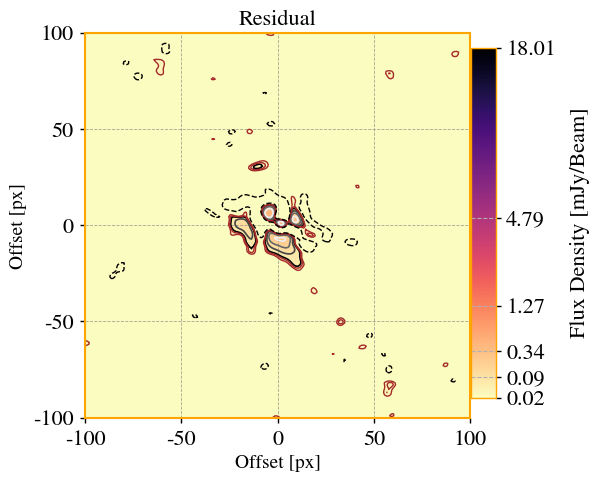

In [206]:
ax = mlibs.eimshow(residual_fit,
             center=center,
             crop=False,box_size=150,vmax_factor=1.0,vmin_factor=3,
             rms=rms,
             vmax=input_data.image_data_2D.max()
            )
ax.set_title('Residual')

Additionally, we can inspect the total integrated flux densities of model and data. 

In [207]:
print(f"Total flux density in model = {smfr.results_fit['flux_density_model'][0]:.2f} mJy")
print(f"Total flux density in data = {smfr.results_fit['flux_data'][0]:.2f} mJy")
print(f"Total flux density in residual = {smfr.results_fit['flux_density_res'][0]:.2f} mJy")


Total flux density in model = 30.97 mJy
Total flux density in data = 31.25 mJy
Total flux density in residual = 0.29 mJy


### Check decomposition results: Compact vs Extended
Now, we can investigate the integrated fluxes between core-compact structures in relation to diffuse ones. 

Note that we consider that the diffuse flux density is the sum between the flux density from the extended model component and the flux density of the residual map.

In [316]:
print(f"Total flux in compact = {smfr.results_fit['flux_density_compact'][0]:.2f} mJy")
print(f"Total flux in extended model = {smfr.results_fit['flux_density_extended_model'][0]:.2f} mJy")

# The total flux density in the diffuse regions are saved in:
print(f"Total flux in extended = {smfr.results_fit['flux_density_ext'][0]:.2f} mJy")
print(f"Total flux residual = {smfr.results_fit['flux_density_res'][0]:.2f} mJy")


Total flux in compact = 16.35 mJy
Total flux in extended model = 14.62 mJy
Total flux in extended = 14.90 mJy
Total flux residual = 0.29 mJy


In the above output, `smfr.results_fit['flux_density_ext']` is computed on the data array `data - compact`, constrained by the data mask above $6\sigma$ and then summing the flux density within that mask.


The quantity `smfr.results_fit['flux_density_extended_model']` is computed on the model array `extended`.
This is calculated using the model itself to create a mask above $6\sigma$ and then summing the flux density within that mask.

For good quality images, both methods should give similar results. For noisy images, they may diverge.

### Physical Sizes of the components
For completeness, we calculate convolved and deconvolved physical properties. 
The properties of the deconvolved model images, referent to compact structures, are stored inside `smfr.results_compact_deconv_morpho`, while properties of convolved model images for compact structures in `smfr.results_compact_conv_morpho`. 

Similarly, we have for the extended structures: `smfr.results_ext_deconv_morpho` and `smfr.results_ext_conv_morpho`. 

Each one of these measurements stores the same quantities that are calculated with the class `mp.radio_image_analysis` (see details in ['morphen/image_analysis/morphen.ipynb'](https://github.com/lucatelli/morphen/blob/main/image_analysis/morphen.ipynb)), for the full radio emission, but now for individual model components. 

In [214]:
# list(smfr.results_compact_conv_morpho.keys())

If you have provided the redshift of the source during the minimisation, the physical sizes can be accessed with:

In [215]:
print(f"1px = {smfr.results_compact_conv_morpho['pix_to_pc'][0]} pc")

1px = 32.1803902504463 pc


If not, you can use the following to calculate the physical sizes.

In [216]:
# Lets calculate the pixel size in physical units (pc).
print(f"Redshift of UGC5101 = {mlibs.find_z_NED('UGC5101')}")
pix_to_pc = mlibs.pixsize_to_pc(z=mlibs.find_z_NED('UGC5101'),
                          cell_size=mlibs.get_cell_size(input_data.filename))
print(f"1 px = {pix_to_pc:.2f} pc")

Redshift of UGC5101 = 0.039367
1 px = 32.18 pc


#### Compact Components
First, let's analyse the results for our compact model(s)/structure(s).
The minimisation results object `smfr` stores three distinct results.
1. A data array containing information of all minimisation parameters: `smfr.fit_results`. This contains the best-fit parameters and standard errors (when possible). The sizes of each model component are labelled as `f1_Rn`, `f2_Rn`, etc, where the index represents the ID of the model component.
2. Four dictionaries, containing the statistical results for the sum of all:
    - Deconvolved compact structures: `smfr.results_compact_deconv_morpho`
    - Convolved compact structures: `smfr.results_compact_conv_morpho`
    - Deconvolved extended structures: `smfr.results_ext_deconv_morpho`
    - Convolved extended structures: `smfr.results_ext_conv_morpho`
    
    Note that they represent the sum of all model components in each case (compact or extended). So, if your model has 3 components compact components, the results will be the sum of all 3 components for sizes, fluxes densities, etc. However, these sizes may not be reliable, as it does not make sense computing the size of multiple components together.
3. To workaround the last issue, we also provide two data arrays, containing the physical properties of each model component fitted to the data (convolved and deconvolved):
    - `smfr.components_conv_props`
    - `smfr.components_deconv_props`
    These arrays contain the physical properties of each model component, and are more reliable than the previous ones, as we can get statistical information for each model component.

In [217]:
smfr.results_fit.keys()

Index(['f1_x0', 'f1_y0', 'f1_PA', 'f1_ell', 'f1_n', 'f1_In', 'f1_Rn', 'f1_cg',
       'f2_x0', 'f2_y0', 'f2_PA', 'f2_ell', 'f2_n', 'f2_In', 'f2_Rn', 'f2_cg',
       's_a', 'f1_x0_err', 'f1_y0_err', 'f1_PA_err', 'f1_ell_err', 'f1_n_err',
       'f1_In_err', 'f1_Rn_err', 'f1_cg_err', 'f2_x0_err', 'f2_y0_err',
       'f2_PA_err', 'f2_ell_err', 'f2_n_err', 'f2_In_err', 'f2_Rn_err',
       'f2_cg_err', 's_a_err', '#imagename', 'residualname', 'beam_size_px',
       'flux_data', 'flux_density_ext_old', 'flux_density_ext',
       'flux_density_ext_self_rms', 'flux_density_extended_model',
       'flux_density_compact', 'flux_density_model', 'flux_density_res'],
      dtype='object')

Lets check the physical properties from the fitting parameters.

In [218]:
# The effective radius in terms of the Sersic Rn parameter.
# This is a deconvolved quantity.
print(f"#############################")
print(f"Component 1 (in this case, the compact component)")
print(f"-----------------------------")
print(f"Rn = {smfr.results_fit['f1_Rn'][0] * pix_to_pc : .1f} +/- {smfr.results_fit['f1_Rn_err'][0]:.1f} pc")
print(f"In = {smfr.results_fit['f1_In'][0]:.3f} +/- {smfr.results_fit['f1_In_err'][0]:.3f} Jy/beam")
print(f"n = {smfr.results_fit['f1_n'][0]:.2f} +/- {smfr.results_fit['f1_n_err'][0]:.2f}")
print(f"q (axis ratio) = {1-smfr.results_fit['f1_ell'][0]:.2f} +/- {smfr.results_fit['f1_ell_err'][0]:2f}")
print(f"-----------------------------")
print(f"#############################")
print(f"Component 2 (in this case, the diffuse component)")
print(f"Rn = {smfr.results_fit['f2_Rn'][0] * pix_to_pc : .1f} +/- {smfr.results_fit['f2_Rn_err'][0]:.1f} pc")
print(f"In = {smfr.results_fit['f2_In'][0]:.4f} +/- {smfr.results_fit['f2_In_err'][0]:.4f} Jy/beam")
print(f"n = {smfr.results_fit['f2_n'][0]:.2f} +/- {smfr.results_fit['f2_n_err'][0]:.2f}")
print(f"q (axis ratio) = {1-smfr.results_fit['f2_ell'][0]:.2f} +/- {smfr.results_fit['f2_ell_err'][0]:2f}")

#############################
Component 1 (in this case, the compact component)
-----------------------------
Rn =  38.1 +/- 0.2 pc
In = 0.108 +/- 0.026 Jy/beam
n = 0.49 +/- 0.19
q (axis ratio) = 0.51 +/- 0.011284
-----------------------------
#############################
Component 2 (in this case, the diffuse component)
Rn =  304.5 +/- 0.5 pc
In = 0.0015 +/- 0.0001 Jy/beam
n = 0.99 +/- 0.02
q (axis ratio) = 0.40 +/- 0.001382


We can also get the derived properties from the model images.

In [219]:
components_conv_props_df = mlibs.pd.DataFrame(smfr.components_conv_props)
components_deconv_props_df = mlibs.pd.DataFrame(smfr.components_deconv_props)

In [220]:
components_deconv_props_df

peak_of_flux total_flux inner_flux  low_flux  mid_flux  \
model_c_deconv_1_props     0.165991   0.016352   0.015263       0.0  0.001085   
model_c_deconv_2_props     0.007035   0.014526   0.010418  0.000282  0.003593   

                       uncertain_flux inner_flux_f low_flux_f mid_flux_f  \
model_c_deconv_1_props       0.000005     0.933365        0.0   0.066354   
model_c_deconv_2_props       0.000233     0.717177    0.01938   0.247371   

                       uncertain_flux_f  ...       I50   flux_rp r_total_flux  \
model_c_deconv_1_props          0.00028  ...       NaN       NaN          NaN   
model_c_deconv_2_props         0.016072  ...  0.000552  0.014642    42.230846   

                       total_flux_rp     R20p      R50p       R80p       R90p  \
model_c_deconv_1_props           NaN      NaN       NaN        NaN        NaN   
model_c_deconv_2_props      0.014641  4.65013  9.379676  16.608922  21.494699   

                             C1p       C2p  
model_c_deconv_1_props       NaN       NaN  
model_c_deconv_2_props  0.552876  0.360144  

[2 rows x 189 columns]

In [221]:
components_conv_props_df

peak_of_flux total_flux inner_flux  low_flux  mid_flux  \
model_c_conv_1_props     0.014813   0.016349   0.014747  0.000003  0.001597   
model_c_conv_2_props      0.00327   0.014625   0.012067  0.000013  0.002537   

                     uncertain_flux inner_flux_f low_flux_f mid_flux_f  \
model_c_conv_1_props       0.000003     0.902001   0.000176   0.097659   
model_c_conv_2_props       0.000007     0.825095   0.000906   0.173486   

                     uncertain_flux_f  ... r_total_flux total_flux_rp  \
model_c_conv_1_props         0.000165  ...    14.526705      0.016351   
model_c_conv_2_props         0.000512  ...     43.69974      0.014628   

                          R20p       R50p       R80p       R90p       C1p  \
model_c_conv_1_props  1.906381   3.360272   5.145429    6.19904  0.431212   
model_c_conv_2_props  5.464893  10.179436  16.929586  21.394479  0.491065   

                           C2p comp_ID  \
model_c_conv_1_props   0.26595       1   
model_c_conv_2_props  0.322578       2   

                                                             model_file  
model_c_conv_1_props  selfcal_image_UGC05101.calibrated.avg12s_trial...  
model_c_conv_2_props  selfcal_image_UGC05101.calibrated.avg12s_trial...  

[2 rows x 189 columns]

In [222]:
components_deconv_props_df['C50radii'].iloc[0]

0.7978845608028654

In [223]:
component_id = 1
print(f"#############################")
print(f"Component 1 (in this case, the compact component)")
print(f"-----------------------------")
# The deconvolved effective radius measured in the deconvolved model image. 
print(f"Deconv R50 ={components_deconv_props_df['C50radii'].iloc[component_id-1] * pix_to_pc : .0f} pc")
# The convolved effective radius measured in the convolved model image. 
print(f"Conv R50 ={components_conv_props_df['C50radii'].iloc[component_id-1]  * pix_to_pc : .0f} pc")
# The deconvolved effective radius measured in the deconvolved model image. 
print(f"Deconv R95 ={components_deconv_props_df['C95radii'].iloc[component_id-1] * pix_to_pc : .0f} pc (full estimated size)")
# The convolved effective radius measured in the convolved model image. 
print(f"Conv R95 ={components_conv_props_df['C95radii'].iloc[component_id-1] * pix_to_pc : .0f} pc (full estimated size)")

#############################
Component 1 (in this case, the compact component)
-----------------------------
Deconv R50 = 26 pc
Conv R50 = 103 pc
Deconv R95 = 60 pc (full estimated size)
Conv R95 = 232 pc (full estimated size)


Note that we were able to recover the physical size down to a size of $\sim~$ 4 smaller than the instrument resolution.

In [224]:
print(f"Beam Size = {smfr.beam_size_pc[0]:.1f} pc")


Beam Size = 193.1 pc


In [225]:
component_id = 2
print(f"#############################")
print(f"Component 2 (in this case, the extended component)")
print(f"-----------------------------")
# The deconvolved effective radius measured in the deconvolved model image. 
print(f"Deconv R50 ={components_deconv_props_df['C50radii'].iloc[component_id-1] * pix_to_pc : .0f} pc")
# The convolved effective radius measured in the convolved model image. 
print(f"Conv R50 ={components_conv_props_df['C50radii'].iloc[component_id-1]  * pix_to_pc : .0f} pc")
# The deconvolved effective radius measured in the deconvolved model image. 
print(f"Deconv R95 ={components_deconv_props_df['C95radii'].iloc[component_id-1] * pix_to_pc : .0f} pc (full estimated size)")
# The convolved effective radius measured in the convolved model image. 
print(f"Conv R95 ={components_conv_props_df['C95radii'].iloc[component_id-1] * pix_to_pc : .0f} pc (full estimated size)")

#############################
Component 2 (in this case, the extended component)
-----------------------------
Deconv R50 = 188 pc
Conv R50 = 225 pc
Deconv R95 = 554 pc (full estimated size)
Conv R95 = 603 pc (full estimated size)


In [226]:
# print(f"#############################")
# print(f"Component 1 (in this case, the compact component)")
# print(f"-----------------------------")
# # The deconvolved effective radius measured in the deconvolved model image. 
# print(f"Deconv R50 ={smfr.results_compact_deconv_morpho['C50radii'][0] * pix_to_pc : .0f} pc")
# # The convolved effective radius measured in the convolved model image. 
# print(f"Conv R50 ={smfr.results_compact_conv_morpho['C50radii'][0] * pix_to_pc : .0f} pc")
# # The deconvolved effective radius measured in the deconvolved model image. 
# print(f"Deconv R95 ={smfr.results_compact_deconv_morpho['C95radii'][0] * pix_to_pc : .0f} pc (full estimated size)")
# # The convolved effective radius measured in the convolved model image. 
# print(f"Conv R95 ={smfr.results_compact_conv_morpho['C95radii'][0] * pix_to_pc : .0f} pc (full estimated size)")

In [227]:
# print(f"#############################")
# print(f"Component 2 (in this case, the extended component)")
# print(f"-----------------------------")
# # The deconvolved effective radius measured in the deconvolved model image. 
# print(f"Deconv R50 ={smfr.results_ext_deconv_morpho['C50radii'][0] * pix_to_pc : .0f} pc")
# # The convolved effective radius measured in the convolved model image. 
# print(f"Conv R50 ={smfr.results_ext_conv_morpho['C50radii'][0] * pix_to_pc : .0f} pc")
# # The deconvolved effective radius measured in the deconvolved model image. 
# print(f"Deconv R95 ={smfr.results_ext_deconv_morpho['C95radii'][0] * pix_to_pc : .0f} pc (full estimated size)")
# # The convolved effective radius measured in the convolved model image. 
# print(f"Conv R95 ={smfr.results_ext_conv_morpho['C95radii'][0] * pix_to_pc : .0f} pc (full estimated size)")

### Compute SFR Estimates for Diffuse Structures and the Brightness Temperature
We now attempt to estimate the star formation rates from the flux density of the diffuse structures.
Note that this is more of a testing phase to compute star-formation estimates.

For star formation rates, some assumptions are made (as discussed in the paper Lucatelli et al., 2024).
But we are interested in the amount of energy that is coming from diffuse structures only, and try to translate that to SFR.

We use the fitting results to compute the SFR. Within `smfr`, information is stored regarding the total flux density in the extended structures (`'flux_density_ext2'`) and the sizes.

The class `radio_star_formation` from `morphen` deals with the calculations, provided the object `smfr`. Note also that you need to provide the redshift of the galaxy. 

In [228]:
SFR = mp.radio_star_formation(input_data,
                              smfr,#seric multifit results object
                              z=mlibs.find_z_NED('UGC5101'))

2024-03-25 18:56:31 - INFO - Using frequency of 10.00 GHz for star formation estimate.
2024-03-25 18:56:31 - INFO - +-----------------+
2024-03-25 18:56:31 - INFO - | SFR Estimates |
2024-03-25 18:56:31 - INFO - +-----------------+
2024-03-25 18:56:31 - INFO -  ==> SFR =147.40 +/- 2.82 Mo/yr
2024-03-25 18:56:31 - INFO - +------------------+
2024-03-25 18:56:31 - INFO - | sSFR Estimates |
2024-03-25 18:56:31 - INFO - +------------------+
2024-03-25 18:56:31 - INFO -  >=> Deconvolved A50 sSFR = 1330.26 Mo/(yr kpc^2)
2024-03-25 18:56:31 - INFO -  >=> Convolved A50 sSFR = 955.29 Mo/(yr kpc^2)
2024-03-25 18:56:31 - INFO -  >=> Deconvolved A95 sSFR = 151.75 Mo/(yr kpc^2)
2024-03-25 18:56:31 - INFO -  >=> Convolved A95 sSFR = 128.46 Mo/(yr kpc^2)
2024-03-25 18:56:31 - INFO - +--------------------------+
2024-03-25 18:56:31 - INFO - | Brightness Temperature |
2024-03-25 18:56:31 - INFO - +--------------------------+
2024-03-25 18:56:31 - INFO -  ==> TB Rn Fit = 0.67 e5 K
2024-03-25 18:56:31 - 

### Estimating the brightness temperatures for all model components

The brightness temperature is calculated using the formula:
$$
T_b = \frac{2 \ln 2}{\pi k_B} \frac{c^{2} (1+z)}{\phi_{\rm maj} \phi_{\rm min}} \frac{S_\nu}{\nu^2}
$$
where $k_B$ is the Boltzmann constant, $z$ the redshift and $\phi_{\rm maj}$, $\phi_{\rm min}$ are the deconvolved semi-major and minor axis of the source.

We are going to use the circular radii approximation, obtained from every deconvolved component. These cicular radii, `C50radii` are derived from the area $A_{50}$, $C_{50} = \sqrt{A_{50}/\pi}$. The conversion from $C_{50}$ to $(\phi_{\rm maj},\phi_{\rm min})$ is given by:
$$
\phi_{\rm min} = 2 C_{50} (1 - e) = 2 C_{50} q
$$
$$
\phi_{\rm maj} = 2 C_{50}
$$
where the axis ratio $q$ is assessed from `components_deconv_props_df['qmo']`.

In [234]:
components_conv_props_df['qmo']

model_c_conv_1_props     0.95057
model_c_conv_2_props    0.478142
Name: qmo, dtype: object

In [235]:
components_deconv_props_df['total_flux_mask']

model_c_deconv_1_props    0.016354
model_c_deconv_2_props    0.014642
Name: total_flux_mask, dtype: object

In [236]:
theta1_R50fit = 2 * components_deconv_props_df['cell_size'] * components_deconv_props_df['C50radii']
theta2_R50fit = (2 * (1 - np.asarray(components_conv_props_df['qm'])) * components_deconv_props_df['cell_size'] * components_deconv_props_df['C50radii'])

In [237]:

TB_R50fit  = mlibs.Tb_source(Snu=components_deconv_props_df['total_flux_mask'],
                            freq=10, #in GHz
                            theta1=theta1_R50fit, theta2=theta2_R50fit,
                            z=mlibs.find_z_NED('UGC5101'))

In [238]:
print(TB_R50fit,'x 10^5 K')

model_c_deconv_1_props    15.223584
model_c_deconv_2_props      0.02436
dtype: object x 10^5 K


## Example 2: Multi-Sersic Fit with multiple model components.

To demonstrate the feasibility of `morphen` to deal with complex structures, we are going to use a more complicated example.
The reference data is a radio image of a galaxy of MCG+12-02-001 with the VLA-A configuration at $\sim$ 6 GHz.

The structure of this galaxy is complex, with multiple emitting regions. 

First, lets load the data.

In [279]:
root_path = '../../data_examples/data_examples_fitting/vla_only/MCG12_C/'
prefix_images = '*MFS-image.fits'
imagelist = mlibs.glob.glob(root_path+prefix_images)
imagelist,residuallist = \
    mlibs.sort_list_by_beam_size(imagelist=imagelist,
                                 return_df = False)


100%|██████████| 1/1 [00:00<00:00, 146.77it/s]

0 >> image_MCG12-02-001.avg12s.calibrated_trial_1_2048x2048_0.05asec_400000.briggs.multiscale..0.5-MFS-image.fits


In [280]:
residuallist

array(['../../data_examples/data_examples_fitting/vla_only/MCG12_C/image_MCG12-02-001.avg12s.calibrated_trial_1_2048x2048_0.05asec_400000.briggs.multiscale..0.5-MFS-residual.fits'],
      dtype=object)

In [282]:
# lets select another image from our list of images. 
idx = 0
input_data=mp.read_data(filename=imagelist[idx],
                        residualname=residuallist[idx])

++>> Image File: image_MCG12-02-001.avg12s.calibrated_trial_1_2048x2048_0.05asec_400000.briggs.multiscale..0.5-MFS-image.fits
++>> Residual File: image_MCG12-02-001.avg12s.calibrated_trial_1_2048x2048_0.05asec_400000.briggs.multiscale..0.5-MFS-residual.fits
-->> No PSF File was provided.


In [283]:
image_data = input_data.image_data_2D
residual_data = input_data.residual_data_2D

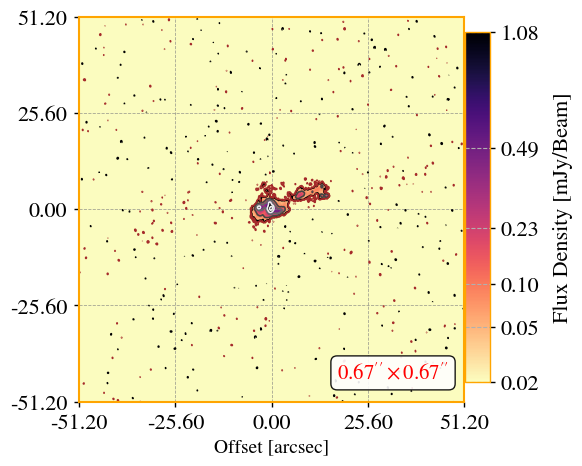

In [285]:
ax=mlibs.eimshow(input_data.filename,add_beam=True,crop=False,box_size=50,
        vmin_factor=3.0,vmax_factor=0.3, #level factor (max from peak, and min from std)
        neg_levels=np.asarray([-3]), # negative contours to draw -- which negative std level?
        CM='magma_r',
       )

[1020 1028    0    0]
00:54:03.986, +73.05.05.400, 5.999e+09Hz, I
13.516608333333332 73.08483333333332


<Axes: xlabel='Offset [arcsec]'>

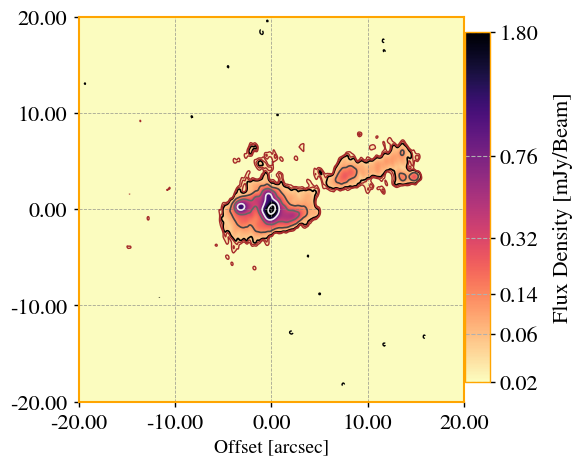

In [286]:
cutout_size = 800
ra,dec,new_filename = mlibs.cutout_2D_radec(imagename=input_data.filename,
                                            residualname=input_data.residualname,
                                            cutout_size = cutout_size,
                                            special_name='')
mlibs.eimshow(new_filename)

In [287]:
for i in mlibs.tqdm(range(len(imagelist))):
    mlibs.cutout_2D_radec(imagename=imagelist[i],
                    residualname=residuallist[i],
                    ra_f=ra,dec_f=dec,
                    cutout_size = cutout_size,
                    special_name='')

100%|██████████| 1/1 [00:00<00:00, 29.40it/s]


In [288]:
prefix_images = '*MFS-image.cutout.fits'
imagelist = mlibs.glob.glob(root_path+prefix_images)
imagelist,residuallist = \
    mlibs.sort_list_by_beam_size(imagelist=imagelist,return_df = False)

100%|██████████| 1/1 [00:00<00:00, 133.67it/s]

0 >> image_MCG12-02-001.avg12s.calibrated_trial_1_2048x2048_0.05asec_400000.briggs.multiscale..0.5-MFS-image.cutout.fits


In [289]:
# lets select another image from our list of images. 
idx = 0 #select one index from the list. 
input_data=mp.read_data(filename=imagelist[idx],
                        residualname=residuallist[idx])
    

++>> Image File: image_MCG12-02-001.avg12s.calibrated_trial_1_2048x2048_0.05asec_400000.briggs.multiscale..0.5-MFS-image.cutout.fits
++>> Residual File: image_MCG12-02-001.avg12s.calibrated_trial_1_2048x2048_0.05asec_400000.briggs.multiscale..0.5-MFS-residual.cutout.fits
-->> No PSF File was provided.


<Axes: xlabel='Offset [arcsec]'>

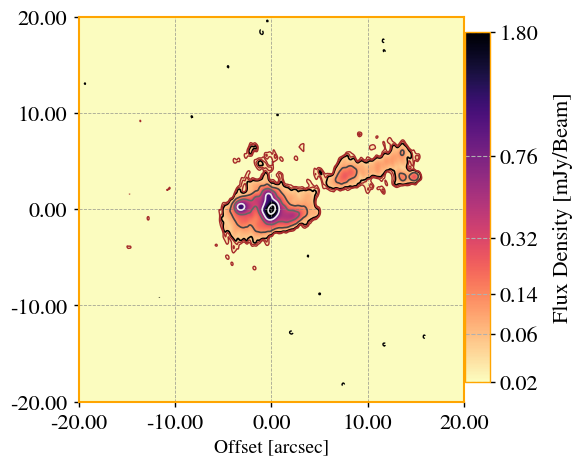

In [290]:
mlibs.eimshow(input_data.filename)

13.340195158250054
+++++++++++++++++++++++
SEP Filter sizes:
    bw,bh=( 13 13 )
    fw,fh=( 13 13 )
+++++++++++++++++++++++
++==>> INFO: Total number of Sources/Structures (deblended) =  7


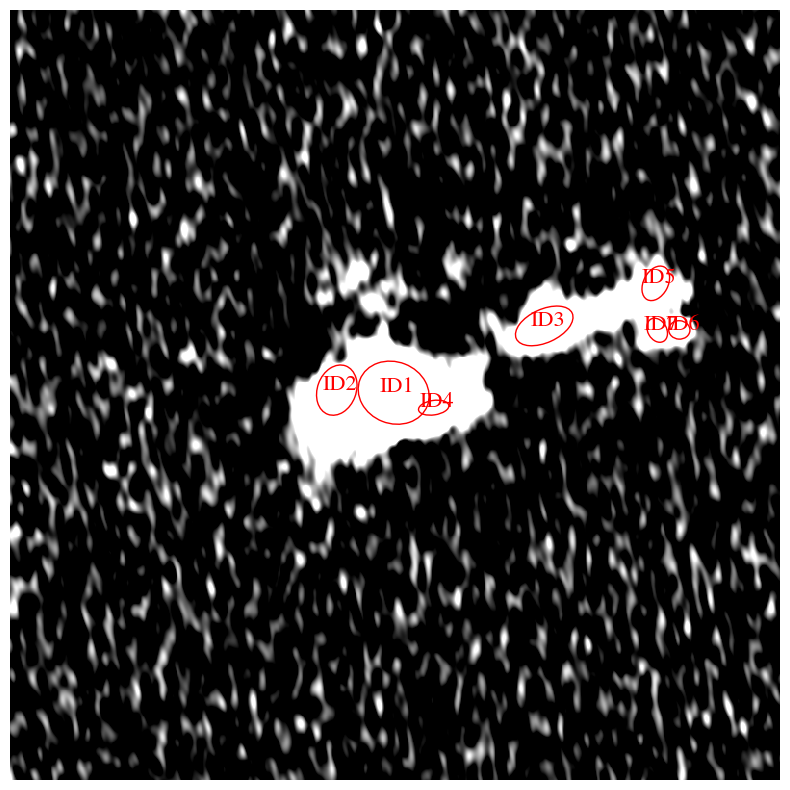

In [291]:
#this is a set of parameters that may work OKAY
bwf, bhf = 1.0, 1.0 # standard value that works for a wide range of images. But, additional check is required!!!!
fwf, fhf = 1.0, 1.0 # standard value that works for a wide range of images. But, additional check is required!!!!
clean_param = 0.5
deblend_cont = 1e-5
sigma = 6
deblend_nthresh = 25
minarea_factor = 1
sigma_mask = 6.0

# ell_size_factor = 2.5
ell_size_factor = 0.3*mlibs.get_ell_size_factor(psf_current = mlibs.get_beam_size_px(input_data.filename)[0])
SE = mp.source_extraction(input_data, 
                          ell_size_factor = ell_size_factor, sigma = sigma,
                          bwf = bwf,bhf = bhf,fwf = fwf, fhf = fhf,
                          clean_param = clean_param, 
                          deblend_cont = deblend_cont, 
                          deblend_nthresh=deblend_nthresh,minarea_factor=minarea_factor,
                          apply_mask=False,sigma_mask=sigma_mask,dilation_size=None,
                          show_petro_plots=True,algorithm='SEP',
                          dry_run=True, obs_type = 'radio')
# plt.imshow(input_data.image_data_2D)

To demonstrate the flexibility of `morphen` Sersic fitting, we start by assuming that we just want to add additional model component to the structures `ID1` and `ID2`, as some diffuse emission is surrounding those structures, and may not be well modelled by single models. Below, we input this information with 
`ids_to_add = ['1','2']`.

13.340195158250054
 ==>  Dilation size is 6 [px]
+++++++++++++++++++++++
SEP Filter sizes:
    bw,bh=( 13 13 )
    fw,fh=( 13 13 )
+++++++++++++++++++++++
++==>> INFO: Total number of Sources/Structures (deblended) =  7


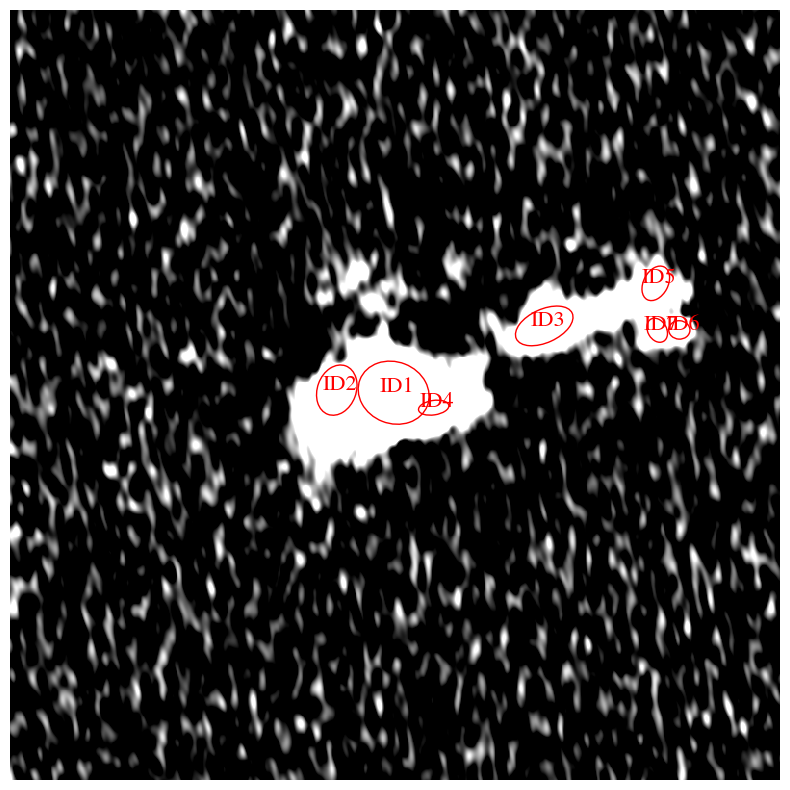

/media/sagauga/xfs_evo/cloud/OnedriveUoM/PhD_UoM/GitHub/morphen_dev/image_decomposition/../libs/libs.py:2417: RuntimeWarning: invalid value encountered in divide
  radial_prof = np.histogram(r, bins, weights=(image * weights * mask))[0] / \


/media/sagauga/xfs_evo/cloud/OnedriveUoM/PhD_UoM/GitHub/morphen_dev/image_decomposition/../libs/libs.py:2417: RuntimeWarning: invalid value encountered in divide
  radial_prof = np.histogram(r, bins, weights=(image * weights * mask))[0] / \


/media/sagauga/xfs_evo/cloud/OnedriveUoM/PhD_UoM/GitHub/morphen_dev/image_decomposition/../libs/libs.py:2417: RuntimeWarning: invalid value encountered in divide
  radial_prof = np.histogram(r, bins, weights=(image * weights * mask))[0] / \


INFO: Using Elliptical Gaussian for Gaussian beam convolution.
# of structures (IDs) to be fitted = 7
# of model components (COMPS) to be fitted = 9


2024-03-25 19:08:46	WARN	componentlist::close	componentlist closed


In [295]:
SE = mp.source_extraction(input_data, ids_to_add=['1','2'],
                          ell_size_factor = ell_size_factor, sigma = sigma,
                          bwf = bwf,bhf = bhf,fwf = fwf, fhf = fhf,
                          clean_param = clean_param, 
                          deblend_cont = deblend_cont, 
                          deblend_nthresh=deblend_nthresh,minarea_factor=minarea_factor,
                          apply_mask=False,sigma_mask=sigma_mask,dilation_size=None,
                          show_petro_plots=False,algorithm='SEP',
                          dry_run=False, obs_type = 'radio')

In [296]:
SE.sources_photometries

{'c1_PA': -56.253255485805944,
 'c1_q': 0.8493559562173575,
 'c1_area': 3769.0,
 'c1_Re': 34.6368295464049,
 'c1_x0c': 398.3399674867067,
 'c1_y0c': 401.38400854514595,
 'c1_label': 1,
 'c1_R50': 17.812962592518502,
 'c1_R20': 9.365673134626926,
 'c1_R80': 28.504700940188037,
 'c1_C1': 0.4833774922453537,
 'c1_Snu': 3.4097711919597042,
 'c1_Rp': 38.138227645529106,
 'c1_Rpidx': 76,
 'c1_rlast': 103,
 'c1_I50': 0.0010805616992252782,
 'c2_PA': 55.42502085445556,
 'c2_q': 0.8454466162775977,
 'c2_area': 1688.0,
 'c2_Re': 23.179885415554555,
 'c2_x0c': 339.37203483122914,
 'c2_y0c': 404.02259317377144,
 'c2_label': 1,
 'c2_R50': 13.250050010002001,
 'c2_R20': 7.232246449289858,
 'c2_R80': 20.43388677735547,
 'c2_C1': 0.4510777657243039,
 'c2_Snu': 0.7449204026679629,
 'c2_Rp': 27.531906381276254,
 'c2_Rpidx': 55,
 'c2_rlast': 68,
 'c2_I50': 0.0004435905872884652,
 'c3_PA': 27.278776994820653,
 'c3_q': 0.5583650877299757,
 'c3_area': 1739.0,
 'c3_Re': 23.52744975711588,
 'c3_x0c': 554.6868

We also need to specify which components are compact. For this example, we are going to consider that `COMP_1`, `COMP_2` and `COMP_6` are compact.
Then, we just specify `comp_ids = ['1','2','6']`.

In [299]:
"""
Lets just specify parameter constraints for the fit.
"""
#                (# of structures       +   # of add components)
#         ==     (detected structures   +   manually added) 
fix_geometry =   [True] * SE.n_IDs      +   [True,True]
dr_fix =            [3] * SE.n_IDs      +   [150,150]
fix_value_n =     [0.5] * SE.n_IDs      +   [None,None]
fix_n =          [True] * SE.n_IDs      +   [False,False]

We fix all positions of detected structures (IDs) to a smaller bound, 
while we increase the bounds for the group of manually added components.

We note that manually added components represents diffuse structures. 
Such diffuse structures are expected to have larger radial sizes and follow a more 
exponential profile, rather than a gaussian profile. In that sense, we set that 
the Sersic index should be free. 

2024-03-25 19:16:01 - INFO -  ++>> Fitting without a mask.



                                                          ..___|**_
                                                  .|||||||||*+@+*__*++.
                                              _||||.           .*+;].,#_
                                         _|||*_                _    .@@@#@.
                                   _|||||_               .@##@#| _||_
       Morphen                |****_                   .@.,/\..@_.
                             #///#+++*|    .       .@@@;#.,.\@.
                              .||__|**|||||*||*+@#];_.  ;,;_
 Geferson Lucatelli                            +\*_.__|**#
                                              |..      .]]
                                               ;@       @.*.
                                                #|       _;]];|.
                                                 ]_          _+;]@.
                                                 _/_             |]\|    .  _
                                              ...._@* __ .

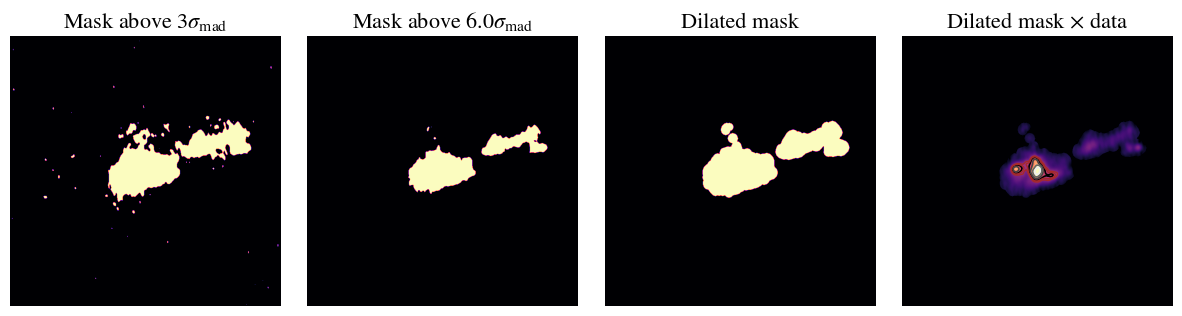

2024-03-25 19:16:02	WARN	componentlist::close	componentlist closed
2024-03-25 19:16:01 - DEBUG - ---------------------------------------
2024-03-25 19:16:01 - DEBUG -  <<< PERFORMING CONVOLUTION WITH JAX >>> 
2024-03-25 19:16:01 - DEBUG - ---------------------------------------
2024-03-25 19:16:01 - DEBUG -  ==> Using clean shuffled background for optmization... 


INFO: Using Elliptical Gaussian for Gaussian beam convolution.
 ++==>> Limiting x0=398.3399674867067+/-3
 ++==>> Limiting y0=401.38400854514595+/-3
++==>> Fixing sersic index of component 1  to 0.5.
 ++==>> Limiting x0=339.37203483122914+/-3
 ++==>> Limiting y0=404.02259317377144+/-3
++==>> Fixing sersic index of component 2  to 0.5.
 ++==>> Limiting x0=554.6868764955133+/-3
 ++==>> Limiting y0=471.2024837862242+/-3
++==>> Fixing sersic index of component 3  to 0.5.
 ++==>> Limiting x0=439.12471727278216+/-3
 ++==>> Limiting y0=386.2713047700701+/-3
++==>> Fixing sersic index of component 4  to 0.5.
 ++==>> Limiting x0=669.708929832388+/-3
 ++==>> Limiting y0=514.7534553136074+/-3
++==>> Fixing sersic index of component 5  to 0.5.
 ++==>> Limiting x0=695.0312044076695+/-3
 ++==>> Limiting y0=467.09953496677855+/-3
++==>> Fixing sersic index of component 6  to 0.5.
 ++==>> Limiting x0=671.827010908404+/-3
 ++==>> Limiting y0=466.86915234092385+/-3
++==>> Fixing sersic index of component

/media/sagauga/xfs_evo/cloud/OnedriveUoM/PhD_UoM/GitHub/morphen_dev/image_decomposition/../libs/libs.py:2417: RuntimeWarning: invalid value encountered in divide
  radial_prof = np.histogram(r, bins, weights=(image * weights * mask))[0] / \
100%|██████████| 10/10 [00:00<00:00, 32.88it/s]


Computing properties of model component:  image_MCG12-02-001.avg12s.calibrated_trial_1_2048x2048_0.05asec_400000.briggs.multiscale..0.5-MFS-image.cutout_dec_model_component_2.fits


/media/sagauga/xfs_evo/cloud/OnedriveUoM/PhD_UoM/GitHub/morphen_dev/image_decomposition/../libs/libs.py:4713: RuntimeWarning: invalid value encountered in divide
  y0peak, x0peak = nd.maximum_position((image / rr2))
/media/sagauga/xfs_evo/cloud/OnedriveUoM/PhD_UoM/GitHub/morphen_dev/image_decomposition/../libs/libs.py:2417: RuntimeWarning: invalid value encountered in divide
  radial_prof = np.histogram(r, bins, weights=(image * weights * mask))[0] / \
100%|██████████| 10/10 [00:00<00:00, 33.93it/s]


Computing properties of model component:  image_MCG12-02-001.avg12s.calibrated_trial_1_2048x2048_0.05asec_400000.briggs.multiscale..0.5-MFS-image.cutout_dec_model_component_3.fits


/media/sagauga/xfs_evo/cloud/OnedriveUoM/PhD_UoM/GitHub/morphen_dev/image_decomposition/../libs/libs.py:4713: RuntimeWarning: invalid value encountered in divide
  y0peak, x0peak = nd.maximum_position((image / rr2))


100%|██████████| 10/10 [00:00<00:00, 36.31it/s]


Computing properties of model component:  image_MCG12-02-001.avg12s.calibrated_trial_1_2048x2048_0.05asec_400000.briggs.multiscale..0.5-MFS-image.cutout_dec_model_component_4.fits


/media/sagauga/xfs_evo/cloud/OnedriveUoM/PhD_UoM/GitHub/morphen_dev/image_decomposition/../libs/libs.py:4713: RuntimeWarning: invalid value encountered in divide
  y0peak, x0peak = nd.maximum_position((image / rr2))


100%|██████████| 10/10 [00:00<00:00, 29.79it/s]


Computing properties of model component:  image_MCG12-02-001.avg12s.calibrated_trial_1_2048x2048_0.05asec_400000.briggs.multiscale..0.5-MFS-image.cutout_dec_model_component_5.fits


/media/sagauga/xfs_evo/cloud/OnedriveUoM/PhD_UoM/GitHub/morphen_dev/image_decomposition/../libs/libs.py:4713: RuntimeWarning: invalid value encountered in divide
  y0peak, x0peak = nd.maximum_position((image / rr2))


100%|██████████| 10/10 [00:00<00:00, 33.92it/s]


Computing properties of model component:  image_MCG12-02-001.avg12s.calibrated_trial_1_2048x2048_0.05asec_400000.briggs.multiscale..0.5-MFS-image.cutout_dec_model_component_6.fits


/media/sagauga/xfs_evo/cloud/OnedriveUoM/PhD_UoM/GitHub/morphen_dev/image_decomposition/../libs/libs.py:4713: RuntimeWarning: invalid value encountered in divide
  y0peak, x0peak = nd.maximum_position((image / rr2))


non real ellipse
non real ellipse
non real ellipse
non real ellipse
non real ellipse
non real ellipse


/media/sagauga/xfs_evo/cloud/OnedriveUoM/PhD_UoM/GitHub/morphen_dev/image_decomposition/../libs/fitEllipse.py:262: RuntimeWarning: invalid value encountered in divide
  qmedian = np.nanmedian(BB / AA)
/media/sagauga/xfs_evo/cloud/OnedriveUoM/PhD_UoM/GitHub/morphen_dev/image_decomposition/../libs/fitEllipse.py:264: RuntimeWarning: invalid value encountered in divide
  qmi = np.nanmedian((BB / AA)[:rsplit])
/media/sagauga/xfs_evo/cloud/OnedriveUoM/PhD_UoM/GitHub/morphen_dev/image_decomposition/../libs/fitEllipse.py:265: RuntimeWarning: invalid value encountered in divide
  qmo = np.nanmedian((BB / AA)[rsplit:])
/media/sagauga/xfs_evo/cloud/OnedriveUoM/PhD_UoM/GitHub/morphen_dev/image_decomposition/../libs/libs.py:2417: RuntimeWarning: invalid value encountered in divide
  radial_prof = np.histogram(r, bins, weights=(image * weights * mask))[0] / \
100%|██████████| 10/10 [00:00<00:00, 36.98it/s]


Computing properties of model component:  image_MCG12-02-001.avg12s.calibrated_trial_1_2048x2048_0.05asec_400000.briggs.multiscale..0.5-MFS-image.cutout_dec_model_component_7.fits


/media/sagauga/xfs_evo/cloud/OnedriveUoM/PhD_UoM/GitHub/morphen_dev/image_decomposition/../libs/libs.py:4713: RuntimeWarning: invalid value encountered in divide
  y0peak, x0peak = nd.maximum_position((image / rr2))


100%|██████████| 10/10 [00:00<00:00, 32.90it/s]


Computing properties of model component:  image_MCG12-02-001.avg12s.calibrated_trial_1_2048x2048_0.05asec_400000.briggs.multiscale..0.5-MFS-image.cutout_dec_model_component_8.fits


/media/sagauga/xfs_evo/cloud/OnedriveUoM/PhD_UoM/GitHub/morphen_dev/image_decomposition/../libs/libs.py:4713: RuntimeWarning: divide by zero encountered in divide
  y0peak, x0peak = nd.maximum_position((image / rr2))


/media/sagauga/xfs_evo/cloud/OnedriveUoM/PhD_UoM/GitHub/morphen_dev/image_decomposition/../libs/libs.py:2417: RuntimeWarning: invalid value encountered in divide
  radial_prof = np.histogram(r, bins, weights=(image * weights * mask))[0] / \
100%|██████████| 10/10 [00:00<00:00, 34.95it/s]


Computing properties of model component:  image_MCG12-02-001.avg12s.calibrated_trial_1_2048x2048_0.05asec_400000.briggs.multiscale..0.5-MFS-image.cutout_dec_model_component_9.fits


/media/sagauga/xfs_evo/cloud/OnedriveUoM/PhD_UoM/GitHub/morphen_dev/image_decomposition/../libs/libs.py:4713: RuntimeWarning: divide by zero encountered in divide
  y0peak, x0peak = nd.maximum_position((image / rr2))


100%|██████████| 10/10 [00:00<00:00, 38.40it/s]


Computing properties of model component:  image_MCG12-02-001.avg12s.calibrated_trial_1_2048x2048_0.05asec_400000.briggs.multiscale..0.5-MFS-image.cutout_model_component_1.fits


/media/sagauga/xfs_evo/cloud/OnedriveUoM/PhD_UoM/GitHub/morphen_dev/image_decomposition/../libs/libs.py:2417: RuntimeWarning: invalid value encountered in divide
  radial_prof = np.histogram(r, bins, weights=(image * weights * mask))[0] / \
100%|██████████| 10/10 [00:00<00:00, 31.07it/s]


Computing properties of model component:  image_MCG12-02-001.avg12s.calibrated_trial_1_2048x2048_0.05asec_400000.briggs.multiscale..0.5-MFS-image.cutout_model_component_2.fits


/media/sagauga/xfs_evo/cloud/OnedriveUoM/PhD_UoM/GitHub/morphen_dev/image_decomposition/../libs/libs.py:4713: RuntimeWarning: invalid value encountered in divide
  y0peak, x0peak = nd.maximum_position((image / rr2))
/media/sagauga/xfs_evo/cloud/OnedriveUoM/PhD_UoM/GitHub/morphen_dev/image_decomposition/../libs/libs.py:2417: RuntimeWarning: invalid value encountered in divide
  radial_prof = np.histogram(r, bins, weights=(image * weights * mask))[0] / \
100%|██████████| 10/10 [00:00<00:00, 28.53it/s]


Computing properties of model component:  image_MCG12-02-001.avg12s.calibrated_trial_1_2048x2048_0.05asec_400000.briggs.multiscale..0.5-MFS-image.cutout_model_component_3.fits


/media/sagauga/xfs_evo/cloud/OnedriveUoM/PhD_UoM/GitHub/morphen_dev/image_decomposition/../libs/libs.py:4713: RuntimeWarning: invalid value encountered in divide
  y0peak, x0peak = nd.maximum_position((image / rr2))


/media/sagauga/xfs_evo/cloud/OnedriveUoM/PhD_UoM/GitHub/morphen_dev/image_decomposition/../libs/libs.py:2417: RuntimeWarning: invalid value encountered in divide
  radial_prof = np.histogram(r, bins, weights=(image * weights * mask))[0] / \
100%|██████████| 10/10 [00:00<00:00, 33.48it/s]


Computing properties of model component:  image_MCG12-02-001.avg12s.calibrated_trial_1_2048x2048_0.05asec_400000.briggs.multiscale..0.5-MFS-image.cutout_model_component_4.fits


/media/sagauga/xfs_evo/cloud/OnedriveUoM/PhD_UoM/GitHub/morphen_dev/image_decomposition/../libs/libs.py:4713: RuntimeWarning: divide by zero encountered in divide
  y0peak, x0peak = nd.maximum_position((image / rr2))
100%|██████████| 10/10 [00:00<00:00, 33.31it/s]


Computing properties of model component:  image_MCG12-02-001.avg12s.calibrated_trial_1_2048x2048_0.05asec_400000.briggs.multiscale..0.5-MFS-image.cutout_model_component_5.fits


/media/sagauga/xfs_evo/cloud/OnedriveUoM/PhD_UoM/GitHub/morphen_dev/image_decomposition/../libs/libs.py:4713: RuntimeWarning: invalid value encountered in divide
  y0peak, x0peak = nd.maximum_position((image / rr2))
100%|██████████| 10/10 [00:00<00:00, 30.90it/s]


Computing properties of model component:  image_MCG12-02-001.avg12s.calibrated_trial_1_2048x2048_0.05asec_400000.briggs.multiscale..0.5-MFS-image.cutout_model_component_6.fits


/media/sagauga/xfs_evo/cloud/OnedriveUoM/PhD_UoM/GitHub/morphen_dev/image_decomposition/../libs/libs.py:4713: RuntimeWarning: invalid value encountered in divide
  y0peak, x0peak = nd.maximum_position((image / rr2))
/media/sagauga/xfs_evo/cloud/OnedriveUoM/PhD_UoM/GitHub/morphen_dev/image_decomposition/../libs/libs.py:2417: RuntimeWarning: invalid value encountered in divide
  radial_prof = np.histogram(r, bins, weights=(image * weights * mask))[0] / \
100%|██████████| 10/10 [00:00<00:00, 36.96it/s]


Computing properties of model component:  image_MCG12-02-001.avg12s.calibrated_trial_1_2048x2048_0.05asec_400000.briggs.multiscale..0.5-MFS-image.cutout_model_component_7.fits


/media/sagauga/xfs_evo/cloud/OnedriveUoM/PhD_UoM/GitHub/morphen_dev/image_decomposition/../libs/libs.py:4713: RuntimeWarning: invalid value encountered in divide
  y0peak, x0peak = nd.maximum_position((image / rr2))
/media/sagauga/xfs_evo/cloud/OnedriveUoM/PhD_UoM/GitHub/morphen_dev/image_decomposition/../libs/libs.py:2417: RuntimeWarning: invalid value encountered in divide
  radial_prof = np.histogram(r, bins, weights=(image * weights * mask))[0] / \
100%|██████████| 10/10 [00:00<00:00, 31.84it/s]


Computing properties of model component:  image_MCG12-02-001.avg12s.calibrated_trial_1_2048x2048_0.05asec_400000.briggs.multiscale..0.5-MFS-image.cutout_model_component_8.fits


/media/sagauga/xfs_evo/cloud/OnedriveUoM/PhD_UoM/GitHub/morphen_dev/image_decomposition/../libs/libs.py:4713: RuntimeWarning: divide by zero encountered in divide
  y0peak, x0peak = nd.maximum_position((image / rr2))
/media/sagauga/xfs_evo/cloud/OnedriveUoM/PhD_UoM/GitHub/morphen_dev/image_decomposition/../libs/libs.py:2417: RuntimeWarning: invalid value encountered in divide
  radial_prof = np.histogram(r, bins, weights=(image * weights * mask))[0] / \
100%|██████████| 10/10 [00:00<00:00, 30.22it/s]


Computing properties of model component:  image_MCG12-02-001.avg12s.calibrated_trial_1_2048x2048_0.05asec_400000.briggs.multiscale..0.5-MFS-image.cutout_model_component_9.fits


/media/sagauga/xfs_evo/cloud/OnedriveUoM/PhD_UoM/GitHub/morphen_dev/image_decomposition/../libs/libs.py:4713: RuntimeWarning: divide by zero encountered in divide
  y0peak, x0peak = nd.maximum_position((image / rr2))
/media/sagauga/xfs_evo/cloud/OnedriveUoM/PhD_UoM/GitHub/morphen_dev/image_decomposition/../libs/fitEllipse.py:262: RuntimeWarning: invalid value encountered in divide
  qmedian = np.nanmedian(BB / AA)
/media/sagauga/xfs_evo/cloud/OnedriveUoM/PhD_UoM/GitHub/morphen_dev/image_decomposition/../libs/fitEllipse.py:264: RuntimeWarning: invalid value encountered in divide
  qmi = np.nanmedian((BB / AA)[:rsplit])
/media/sagauga/xfs_evo/cloud/OnedriveUoM/PhD_UoM/GitHub/morphen_dev/image_decomposition/../libs/fitEllipse.py:265: RuntimeWarning: invalid value encountered in divide
  qmo = np.nanmedian((BB / AA)[rsplit:])
/media/sagauga/xfs_evo/cloud/OnedriveUoM/PhD_UoM/GitHub/morphen_dev/image_decomposition/../libs/libs.py:2417: RuntimeWarning: invalid value encountered in divide
  ra

  ++>> Total component IDs modelled: ['1' '2' '3' '4' '5' '6' '7' '8' '9']
  ++>> IDs attributed to compact structures: ['1', '2', '6']
  ++>> IDs attributed to extended structures: ['3', '4', '5', '7', '8', '9']


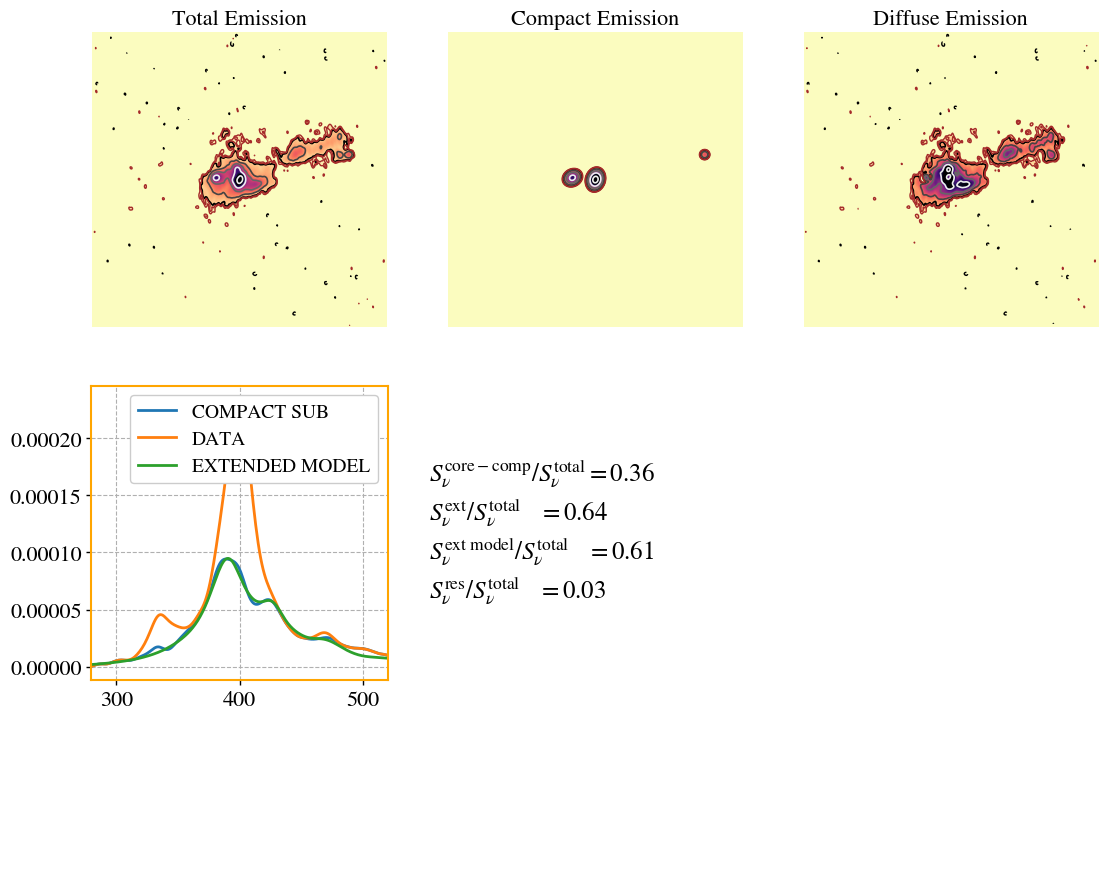

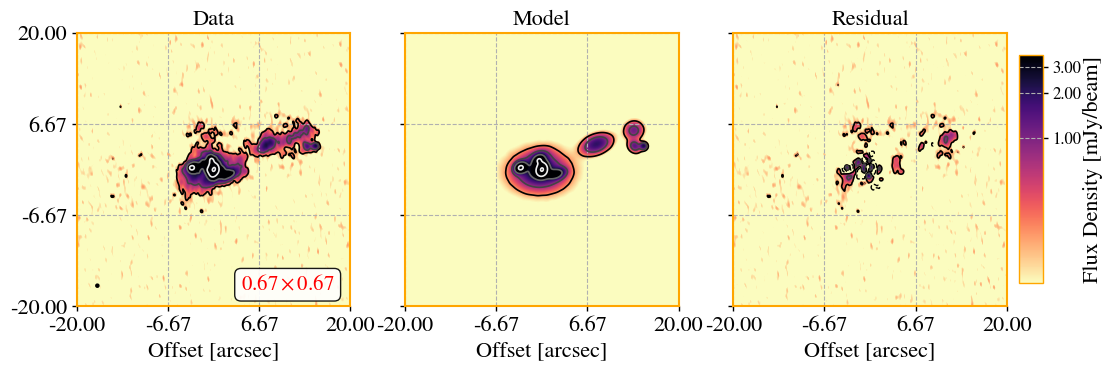

/media/sagauga/xfs_evo/cloud/OnedriveUoM/PhD_UoM/GitHub/morphen_dev/image_decomposition/../libs/libs.py:2417: RuntimeWarning: invalid value encountered in divide
  radial_prof = np.histogram(r, bins, weights=(image * weights * mask))[0] / \


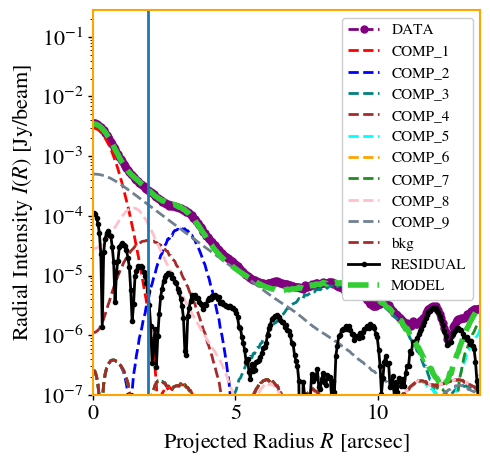

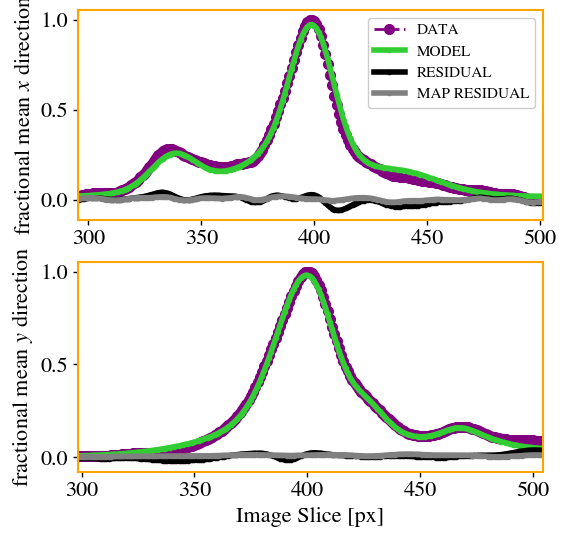

/media/sagauga/xfs_evo/cloud/OnedriveUoM/PhD_UoM/GitHub/morphen_dev/image_decomposition/../libs/libs.py:2417: RuntimeWarning: invalid value encountered in divide
  radial_prof = np.histogram(r, bins, weights=(image * weights * mask))[0] / \
/media/sagauga/xfs_evo/cloud/OnedriveUoM/PhD_UoM/GitHub/morphen_dev/image_decomposition/../libs/libs.py:2417: RuntimeWarning: invalid value encountered in divide
  radial_prof = np.histogram(r, bins, weights=(image * weights * mask))[0] / \
/media/sagauga/xfs_evo/cloud/OnedriveUoM/PhD_UoM/GitHub/morphen_dev/image_decomposition/../libs/libs.py:4713: RuntimeWarning: divide by zero encountered in divide
  y0peak, x0peak = nd.maximum_position((image / rr2))
/media/sagauga/xfs_evo/cloud/OnedriveUoM/PhD_UoM/GitHub/morphen_dev/image_decomposition/../libs/libs.py:2417: RuntimeWarning: invalid value encountered in divide
  radial_prof = np.histogram(r, bins, weights=(image * weights * mask))[0] / \
/media/sagauga/xfs_evo/cloud/OnedriveUoM/PhD_UoM/GitHub/morp

/media/sagauga/xfs_evo/cloud/OnedriveUoM/PhD_UoM/GitHub/morphen_dev/image_decomposition/../libs/libs.py:2417: RuntimeWarning: invalid value encountered in divide
  radial_prof = np.histogram(r, bins, weights=(image * weights * mask))[0] / \
2024-03-25 19:27:11 - INFO - +--------------------------------+
2024-03-25 19:27:11 - INFO - | Core-Compact Component Sizes |
2024-03-25 19:27:11 - INFO - +--------------------------------+
2024-03-25 19:27:11 - INFO -  >=> Beam Size = 13.00 px
2024-03-25 19:27:11 - INFO -  >=> Beam Size = 214.57  pc
2024-03-25 19:27:11 - INFO -  >=> Rn Main Compact = 178.76  pc
2024-03-25 19:27:11 - INFO -  >=> C50 Compact Deconv Radii = 189.93  pc
2024-03-25 19:27:11 - INFO -  >=> C50 Compact Conv Radii = 245.15  pc
2024-03-25 19:27:11 - INFO -  >=> C95 Compact Deconv Radii = 487.63  pc
2024-03-25 19:27:11 - INFO -  >=> C95 Compact Conv Radii = 628.15  pc
2024-03-25 19:27:11 - INFO - +----------------------------+
2024-03-25 19:27:11 - INFO - | Extended Component 

In [300]:
reload_libs()
smfr2 = mp.sersic_multifit_radio(input_data,
                                SE, #source extraction object, from previous step
                                convolution_mode='GPU',
                                which_residual = 'shuffled', #natural or shuffled (natural is experimental!)
                                fix_geometry=fix_geometry, #for stability purposes, keep True for now. 
                                comp_ids=['1','2','6'],# which component label is compact?
                                dr_fix=dr_fix,#for each component, radial element size to fix (x0,y0) positions
                                fix_value_n=fix_value_n,#for each component, the Sersic index value to be fixed. 
                                fix_n=fix_n,#for each component, fix or not the Sersic index. 
                                aspect='elliptical',#elliptical or circular gaussian for beam convolution? 
                                z = mlibs.find_z_NED('MCG+12-02-001'))

In [301]:
smfr2.result_mini.params

Parameters([('f1_x0', <Parameter 'f1_x0', value=398.90838998635104 +/- 0.0056, bounds=[395.3399674867067:401.3399674867067]>), ('f1_y0', <Parameter 'f1_y0', value=398.38400855009206 +/- 0.0118, bounds=[398.38400854514595:404.38400854514595]>), ('f1_PA', <Parameter 'f1_PA', value=-105.27686473270529 +/- 0.0851, bounds=[-146.25325548580594:33.746744514194056]>), ('f1_ell', <Parameter 'f1_ell', value=0.301288087552655 +/- 0.000778, bounds=[0.030128808756528503:0.301288087565285]>), ('f1_n', <Parameter 'f1_n', value=0.5099999999838029 +/- 0.0036, bounds=[0.49:0.51]>), ('f1_In', <Parameter 'f1_In', value=0.002306042932749633 +/- 1.36e-05, bounds=[0.00010805616992252783:0.5402808496126391]>), ('f1_Rn', <Parameter 'f1_Rn', value=10.830210352697666 +/- 0.175, bounds=[3.562592518503701:26.719443888777754]>), ('f1_cg', <Parameter 'f1_cg', value=-0.009987469848526094 +/- 0.0108, bounds=[-0.01:0.01]>), ('f2_x0', <Parameter 'f2_x0', value=336.37203483678553 +/- 0.01, bounds=[336.37203483122914:342.37203483122914]>), ('f2_y0', <Parameter 'f2_y0', value=403.33953726055233 +/- 0.00953, bounds=[401.02259317377144:407.02259317377144]>), ('f2_PA', <Parameter 'f2_PA', value=29.342006539516554 +/- 0.217, bounds=[-34.57497914554444:145.42502085445557]>), ('f2_ell', <Parameter 'f2_ell', value=0.24687349647095347 +/- 0.00168, bounds=[0.030910676744480472:0.3091067674448047]>), ('f2_n', <Parameter 'f2_n', value=0.5099999999859117 +/- 0.0094, bounds=[0.49:0.51]>), ('f2_In', <Parameter 'f2_In', value=0.0008538293949324732 +/- 1.36e-05, bounds=[4.435905872884652e-05:0.2217952936442326]>), ('f2_Rn', <Parameter 'f2_Rn', value=9.869144946640162 +/- 0.421, bounds=[2.6500100020004003:19.875075015003002]>), ('f2_cg', <Parameter 'f2_cg', value=-0.009999999982065555 +/- 0.0299, bounds=[-0.01:0.01]>), ('f3_x0', <Parameter 'f3_x0', value=557.5017201801752 +/- 0.0623, bounds=[551.6868764955133:557.6868764955133]>), ('f3_y0', <Parameter 'f3_y0', value=471.26532140366993 +/- 0.0424, bounds=[468.2024837862242:474.2024837862242]>), ('f3_PA', <Parameter 'f3_PA', value=20.899521914050464 +/- 0.178, bounds=[-62.72122300517935:117.27877699482065]>), ('f3_ell', <Parameter 'f3_ell', value=0.44442996501139304 +/- 0.00218, bounds=[0.08832698245400486:0.75]>), ('f3_n', <Parameter 'f3_n', value=0.5099999999877347 +/- 0.00867, bounds=[0.49:0.51]>), ('f3_In', <Parameter 'f3_In', value=0.00010734659551315605 +/- 1.67e-06, bounds=[7.814679526442584e-06:0.03907339763221292]>), ('f3_Rn', <Parameter 'f3_Rn', value=29.1067213438295 +/- 1.65, bounds=[3.880896179235847:29.10672134426885]>), ('f3_cg', <Parameter 'f3_cg', value=-0.009999999985795753 +/- 0.0288, bounds=[-0.01:0.01]>), ('f4_x0', <Parameter 'f4_x0', value=439.93075926932266 +/- 0.0465, bounds=[436.12471727278216:442.12471727278216]>), ('f4_y0', <Parameter 'f4_y0', value=384.9411408305261 +/- 0.0245, bounds=[383.2713047700701:389.2713047700701]>), ('f4_PA', <Parameter 'f4_PA', value=16.356414612364652 +/- 0.162, bounds=[-81.41724446108022:98.58275553891978]>), ('f4_ell', <Parameter 'f4_ell', value=0.525966630644702 +/- 0.0023, bounds=[0.10463056663899524:0.75]>), ('f4_n', <Parameter 'f4_n', value=0.5099299740991241 +/- 0.0151, bounds=[0.49:0.51]>), ('f4_In', <Parameter 'f4_In', value=0.00027221022200183195 +/- 6.86e-06, bounds=[1.4942065217837809e-05:0.07471032608918904]>), ('f4_Rn', <Parameter 'f4_Rn', value=16.604148547099676 +/- 1.26, bounds=[2.213886472981102:16.604148547358264]>), ('f4_cg', <Parameter 'f4_cg', value=-0.009999999984846932 +/- 0.0448, bounds=[-0.01:0.01]>), ('f5_x0', <Parameter 'f5_x0', value=666.7089298401659 +/- 0.0879, bounds=[666.708929832388:672.708929832388]>), ('f5_y0', <Parameter 'f5_y0', value=511.75345532114704 +/- 0.104, bounds=[511.75345531360745:517.7534553136074]>), ('f5_PA', <Parameter 'f5_PA', value=21.27626085168777 +/- 3.68, bounds=[-25.587377282515675:154.41262271748434]>), ('f5_ell', <Parameter 'f5_ell', value=0.06544022628564944 +/- 0.00871, bounds=[0.06537557596518366:0.75]>), ('f5_n', 

## The structure of the diffuse emission
Lets visualise the model images of our fitting. 
Note that we explicitly specify below the model components that are compact 
(the same ones that were specified when running `mp.sersic_multifit_radio`).

Text(0.5, 1.0, 'Data')

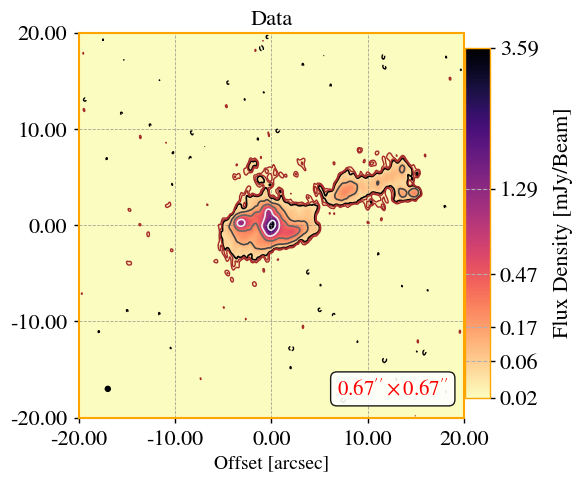

In [302]:
center = mlibs.nd.maximum_position(input_data.image_data_2D)
# center = (center[1]+90,center[0])
# center = (int(smfr.results_fit['f1_x0'][0]),int(smfr.results_fit['f1_y0'][0]))
rms = input_data.rms_res
ax = mlibs.eimshow(input_data.filename,
                   center=center,add_beam=True,
                   crop=False,box_size=280,vmax_factor=1.0,
                   vmax=input_data.image_data_2D.max(),rms=rms)
ax.set_title('Data')

Text(0.5, 1.0, 'Diffuse Emission')

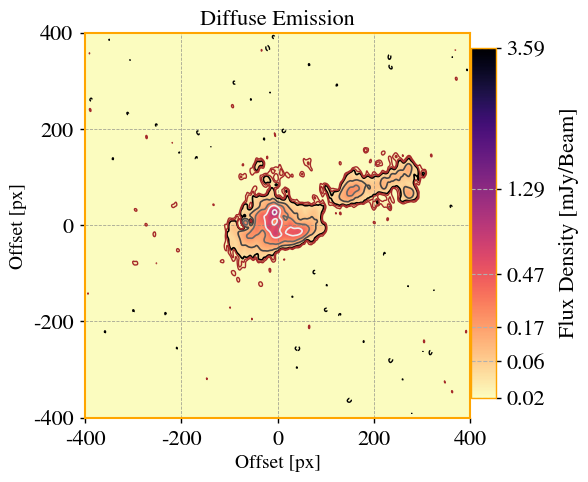

In [303]:
ax = mlibs.eimshow(input_data.image_data_2D
                   -smfr2.compact_model,
                   crop=False,box_size=280,vmax_factor=1.0,
                   center=center,
                   rms=rms,add_beam=True,
                   vmax=input_data.image_data_2D.max())
# ax = mlibs.add_beam_to_image(input_data.filename, ax=ax, dx=3,
#                         cell_size=mlibs.get_cell_size(input_data.filename))
ax.set_title('Diffuse Emission')

Text(0.5, 1.0, 'Compact Deconvolved')

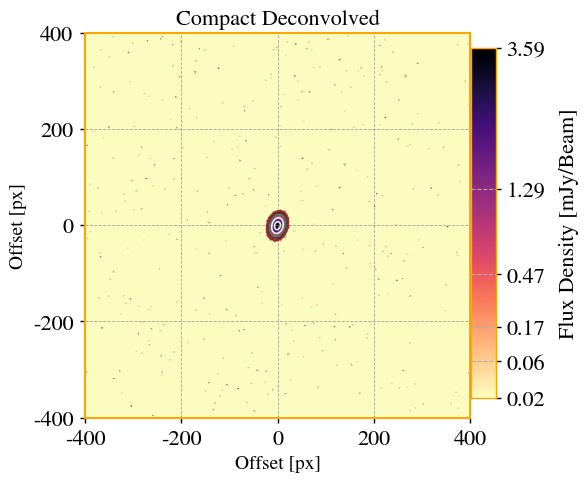

In [304]:
ax=mlibs.eimshow(smfr2.models[0]['model_c1'],
           crop=False,box_size=280,
           rms=input_data.rms_res,
           vmax=input_data.image_data_2D.max())
ax.set_title('Compact Deconvolved')

Text(0.5, 1.0, 'Compact Convolved')

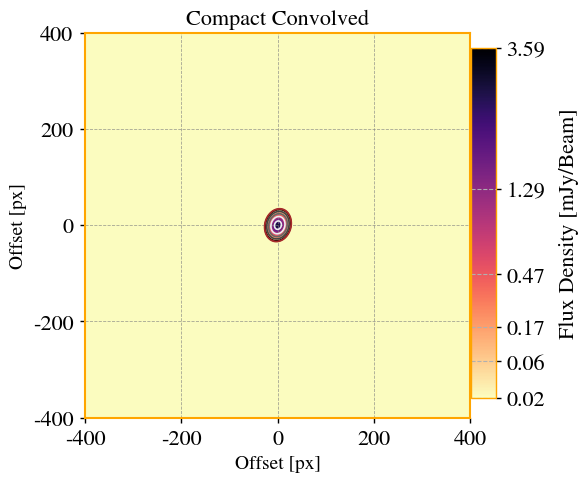

In [306]:
ax=mlibs.eimshow(smfr2.models[0]['model_c1_conv'],
           crop=False,box_size=280,
           center=center,
           rms=input_data.rms_res,
           vmax=input_data.image_data_2D.max())
ax.set_title('Compact Convolved')

Text(0.5, 1.0, 'Model Deconvolved')

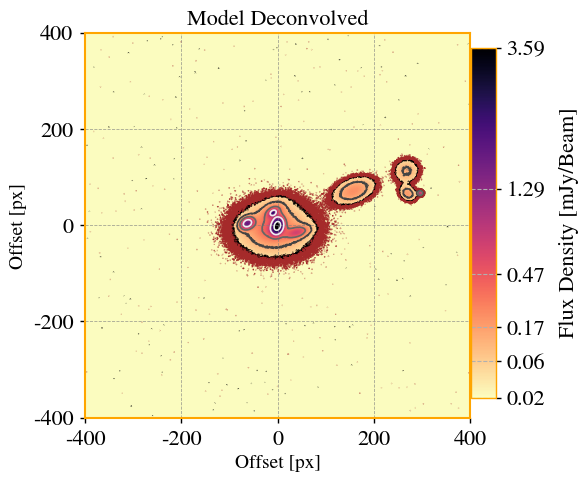

In [325]:
ax=mlibs.eimshow(smfr2.models[0]['model_total_dec'],
           crop=False,box_size=280,rms=rms,
           center=center,
           vmax=input_data.image_data_2D.max())
ax.set_title('Model Deconvolved')

Text(0.5, 1.0, 'Model Convolved')

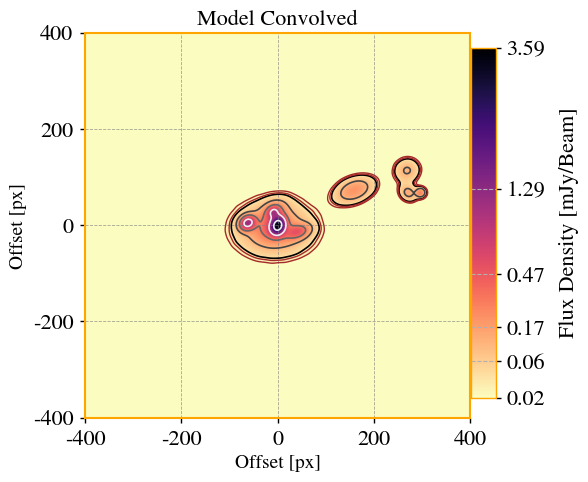

In [326]:
ax=mlibs.eimshow(smfr2.models[0]['model_total_conv'],
           crop=False,box_size=280,rms=input_data.rms_res,
           vmax=input_data.image_data_2D.max())
ax.set_title('Model Convolved')

Text(0.5, 1.0, 'Residual')

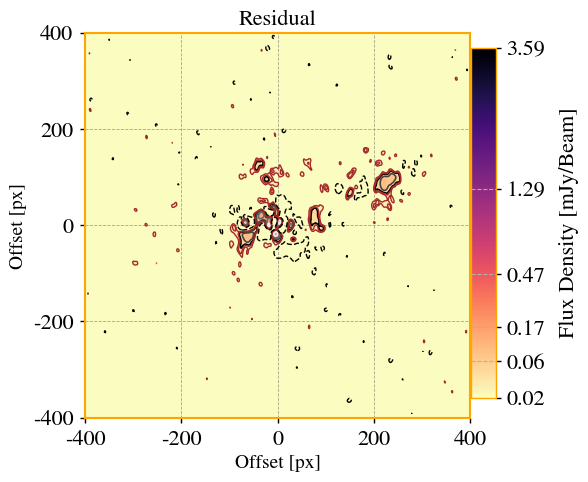

In [309]:
ax = mlibs.eimshow(input_data.image_data_2D- smfr2.models[0]['model_total_conv'],
             center=center,
             crop=False,box_size=280,vmax_factor=1.0,vmin_factor=3,
             rms=rms,
             vmax=input_data.image_data_2D.max()
            )
ax.set_title('Residual')

In [311]:
print(f"Total flux density in model = {smfr2.results_fit['flux_density_model'][0]:.2f} mJy")
print(f"Total flux density in data = {smfr2.results_fit['flux_data'][0]:.2f} mJy")
print(f"Total flux density in residual = {smfr2.results_fit['flux_density_res'][0]:.2f} mJy")


Total flux density in model = 32.61 mJy
Total flux density in data = 33.53 mJy
Total flux density in residual = 0.92 mJy


In [315]:
print(f"Total flux in compact = {smfr2.results_fit['flux_density_compact'][0]:.2f} mJy")
print(f"Total flux in extended model = {smfr2.results_fit['flux_density_extended_model'][0]:.2f} mJy")

# The total flux density in the diffuse regions are saved in:
print(f"Total flux in extended = {smfr2.results_fit['flux_density_ext'][0]:.2f} mJy")
print(f"Total flux residual = {smfr2.results_fit['flux_density_res'][0]:.2f} mJy")


Total flux in compact = 12.13 mJy
Total flux in extended model = 20.48 mJy
Total flux in extended = 21.41 mJy
Total flux residual = 0.92 mJy


### Statistical properties of each component
We can access the statistical properties of each component by using the dataframes `smfr.components_deconv_props` and `smfr.components_conv_props`, where the first one contains statistics determined on the deconvolved images while the second one on the convolved images. 

In [327]:
components_conv_props_df = mlibs.pd.DataFrame(smfr2.components_conv_props)
components_deconv_props_df = mlibs.pd.DataFrame(smfr2.components_deconv_props)

In [328]:
print(f"1px = {smfr2.results_compact_conv_morpho['pix_to_pc'][0]} pc")

1px = 16.505660691007023 pc


In [329]:
pix_to_pc = smfr2.results_compact_conv_morpho['pix_to_pc'][0]

In [332]:
components_conv_props_df

peak_of_flux total_flux inner_flux  low_flux  mid_flux  \
model_c_conv_1_props     0.002952    0.00888   0.007979  0.000004  0.000894   
model_c_conv_2_props     0.001054    0.00294   0.002642  0.000004  0.000292   
model_c_conv_3_props     0.000192   0.002274   0.002144  0.000007  0.000119   
model_c_conv_4_props     0.000386   0.001672   0.001507  0.000006  0.000155   
model_c_conv_5_props     0.000113   0.000868   0.000828  0.000005  0.000032   
model_c_conv_6_props     0.000232   0.000306   0.000277  0.000002  0.000026   
model_c_conv_7_props     0.000131   0.000526   0.000484  0.000004  0.000035   
model_c_conv_8_props      0.00091    0.00322    0.00248   0.00002  0.000705   
model_c_conv_9_props     0.000606   0.012067   0.009928  0.000013  0.002119   

                     uncertain_flux inner_flux_f low_flux_f mid_flux_f  \
model_c_conv_1_props       0.000003      0.89854   0.000462   0.100656   
model_c_conv_2_props       0.000003      0.89855    0.00127   0.099227   
model_c_conv_3_props       0.000005     0.942725   0.003037   0.052152   
model_c_conv_4_props       0.000004     0.901228   0.003414   0.092948   
model_c_conv_5_props       0.000003      0.95356   0.005603    0.03695   
model_c_conv_6_props       0.000001     0.906012   0.005465   0.084348   
model_c_conv_7_props       0.000003     0.919727   0.007965   0.066549   
model_c_conv_8_props       0.000015     0.770147   0.006207   0.219058   
model_c_conv_9_props       0.000007     0.822791    0.00104    0.17563   

                     uncertain_flux_f  ... arcsec_to_pc     bmaj_pc  \
model_c_conv_1_props         0.000342  ...   211.757153  141.244087   
model_c_conv_2_props         0.000952  ...   211.757153  141.244087   
model_c_conv_3_props         0.002086  ...   211.757153  141.244087   
model_c_conv_4_props          0.00241  ...   211.757153  141.244087   
model_c_conv_5_props         0.003887  ...   211.757153  141.244087   
model_c_conv_6_props         0.004175  ...   211.757153  141.244087   
model_c_conv_7_props         0.005759  ...   211.757153  141.244087   
model_c_conv_8_props         0.004589  ...   211.757153  141.244087   
model_c_conv_9_props         0.000539  ...   211.757153  141.244087   

                         bmin_pc         BA_pc  pix_to_pc cell_size  \
model_c_conv_1_props  141.244087  22605.024078  10.587858      0.05   
model_c_conv_2_props  141.244087  22605.024078  10.587858      0.05   
model_c_conv_3_props  141.244087  22605.024078  10.587858      0.05   
model_c_conv_4_props  141.244087  22605.024078  10.587858      0.05   
model_c_conv_5_props  141.244087  22605.024078  10.587858      0.05   
model_c_conv_6_props  141.244087  22605.024078  10.587858      0.05   
model_c_conv_7_props  141.244087  22605.024078  10.587858      0.05   
model_c_conv_8_props  141.244087  22605.024078  10.587858      0.05   
model_c_conv_9_props  141.244087  22605.024078  10.587858      0.05   

                     area_beam_2Rp area_beam_R50 comp_ID  \
model_c_conv_1_props      8.963914      2.410051       1   
model_c_conv_2_props      8.123419      2.196572       2   
model_c_conv_3_props     32.483411      8.671266       3   
model_c_conv_4_props     12.200581      3.217246       4   
model_c_conv_5_props     18.339379      5.404503       5   
model_c_conv_6_props      3.914599       0.97865       6   
model_c_conv_7_props     11.756901      2.939225       7   
model_c_conv_8_props     15.339592      3.420634       8   
model_c_conv_9_props     99.311324     20.434342       9   

                                                             model_file  
model_c_conv_1_props  image_MCG12-02-001.avg12s.calibrated_trial_1_2...  
model_c_conv_2_props  image_MCG12-02-001.avg12s.calibrated_trial_1_2...  
model_c_conv_3_props  image_MCG12-02-001.avg12s.calibrated_trial_1_2...  
model_c_conv_4_props  image_MCG12-02-001.avg12s.calibrated_trial_1_2...  
model_c_conv_5_props  image_MCG12-02-001.avg12s.calibrated_trial_1_2...  
model_c_conv_6_props  

### Compute SFR Estimates for Diffuse Structures

In [333]:
SFR = mp.radio_star_formation(input_data,
                              smfr2,
                              z=mlibs.find_z_NED('MCG+12-02-001'))

2024-03-25 21:19:27 - INFO - Using frequency of 6.00 GHz for star formation estimate.
2024-03-25 21:19:27 - INFO - +-----------------+
2024-03-25 21:19:27 - INFO - | SFR Estimates |
2024-03-25 21:19:27 - INFO - +-----------------+
2024-03-25 21:19:27 - INFO -  ==> SFR =24.65 +/- 1.06 Mo/yr
2024-03-25 21:19:27 - INFO - +------------------+
2024-03-25 21:19:27 - INFO - | sSFR Estimates |
2024-03-25 21:19:27 - INFO - +------------------+
2024-03-25 21:19:27 - INFO -  >=> Deconvolved A50 sSFR = 19.79 Mo/(yr kpc^2)
2024-03-25 21:19:27 - INFO -  >=> Convolved A50 sSFR = 18.39 Mo/(yr kpc^2)
2024-03-25 21:19:27 - INFO -  >=> Deconvolved A95 sSFR = 3.40 Mo/(yr kpc^2)
2024-03-25 21:19:27 - INFO -  >=> Convolved A95 sSFR = 2.94 Mo/(yr kpc^2)
2024-03-25 21:19:27 - INFO - +--------------------------+
2024-03-25 21:19:27 - INFO - | Brightness Temperature |
2024-03-25 21:19:27 - INFO - +--------------------------+
2024-03-25 21:19:27 - INFO -  ==> TB Rn Fit = 0.01 e5 K
2024-03-25 21:19:27 - INFO -  =

## Determine Brightness Temperatures

In [337]:
theta1_R50fit = 2 * components_deconv_props_df['cell_size'] * components_deconv_props_df['C50radii']
theta2_R50fit = (2 * (1 - components_deconv_props_df['qm']) * components_deconv_props_df['cell_size'] * components_deconv_props_df['C50radii'])

In [366]:
# we use the flux density from the convolved images, but the sizes from the deconvolved images.
TB_R50fit  = mlibs.Tb_source(Snu=components_conv_props_df['total_flux_mask'],
                            freq=6, #in GHz
                            theta1=np.asarray(theta1_R50fit), 
                            theta2=np.asarray(theta2_R50fit),
                            z=mlibs.find_z_NED('MCG+12-02-001'))

In [367]:
print(TB_R50fit,'x 10^5 K')

model_c_conv_1_props    0.018369
model_c_conv_2_props    0.009409
model_c_conv_3_props    0.000713
model_c_conv_4_props     0.00132
model_c_conv_5_props    0.003966
model_c_conv_6_props    0.015791
model_c_conv_7_props    0.001634
model_c_conv_8_props    0.006148
model_c_conv_9_props     0.00173
Name: total_flux_mask, dtype: object x 10^5 K
